# DSE Capstone Project: Climate Impacts on Salmon Productivity in the U.S

**Tony Hoang; Indrani Pal, PhD ; Ronak Etemadpour, PhD**  
**City College of New York**

# Introduction

Salmon plays an important role in the commercial Fisheries & Seafood industry. Among the 2000+ species being caught in the U.S, Salmon is the most valuable catch in terms of dollar value: $700 millions (+ 36% from 2016). Atlantic salmon was the leading species for marine finfish aquaculture, with 35.7 million pounds produced in 2016. 

Salmon are the biological foundation of river ecosystems, returning ocean nutrients to the rivers and streams where they were born, feeding wildlife and even the forests with their bodies. For example, spawning salmon in southeastern Alaska contribute up to 25% of the nitrogen in the foliage of trees, resulting in tree growth rates nearly three-times higher than in areas without salmon spawning.

Therefore, it’s important to understand what could impact the salmon fisheries productivity in the U.S. One of the key and most studied factor is the change in environment. Warming temperature of the freshwater streams would make salmon more susceptible to predators, parasites and disease. Although a great amount of academic work has been focusing on the link between various environment factors and salmon habitat, there is still an unmet need to better understand such relationships and what they mean from an economic/business perspective. With an increasing availability of data and robust data science techniques, a framework that can forecast the future outcome of salmon production with high accuracy is also desirable. 

This research project aims to study the impacts of climate on Salmon productivity in the U.S by examining both global and local environmental indicators using large-scale correlation analysis. It also proposes a prediction framework for Salmon productions by employing various machine learning techniques. 

# Data Description

1. U.S. Commercial Fisheries Statistics:
Annual statistics for fish and shellfish that are landed and sold in the 50 states by U.S. fishermen and do not include landings made in U.S. territories or by foreign fishermen. Data can be summarized in either pounds and dollar value of commercial landings from 1950 – 2017 by years, states and species; by years, states, species and fishing gears; or years, states, species, finfish or shellfish groups, and price per pound. 
	<br>Format: CSV    
    <br>
2. Northwest environmental indicators 
Various statistics collected at both the 46050 station located at Stonewall Bank, 20NM West of Newport, OR and the New Port Line NH-5, located roughly 9km off shore from New Port, OR. There are a total of 19 indicators, which includes 10 climate factors and 9 biological factors. The data frequency is annual, covering a period from 1998 – 2017 for a total of 20 data points. 
	<br>Format: CSV   
     <br>
3. NOAA Extended Reconstructed Sea Surface Temperature (SST) V4
A global monthly SST analysis from 1854 to the present derived from ICOADS data with missing data filled in by statistical methods. Production of the SST is on a 2° latitude × 2° longitude global grid with dimension of 89 x 180, covering period from 1954 – 2017.
	<br>Format: NetCDF4  
     <br>
4. Multivariate ENSO Index Version 2 (MEI.v2)
The bi-monthly Multivariate El Niño/Southern Oscillation (ENSO) index (MEI.v2) is the time series that combines five different oceanic and atmospheric variables. It gives real-time indications of ENSO intensity, and provides a context for meaningful comparative study of evolving El Nino/La Nina conditions.
	<br>Format: DATA  
    <br>
       

# Data Analysis & Results

In examining the impacts of climate on Salmon productivity, I will first look at the macro factors, with a focus on Sea Surface Temperature (SST), and then at the local factors. I expect results from analysis on both scale would support the hypothesis that there is a strong relationship between selected climate indicators and Salmon production in the U.S.  

The first step in that process is to read in U.S Fishery landings data, and then select only one that are related to Salmon.  



### U.S Fishery landings data

In [7]:
import datetime as dt  # Python standard library datetime  module
import numpy as np
from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

import pandas as pd 

%matplotlib inline

import math

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold

import statsmodels.api as sm

from pylab import *

Because of technological advancement (better catch techniques, larger ships, etc), the amount of Salmon production would naturally increase over time. In order to seperate this impact, I'm using a technique called _Detrending_.  
<br>
<img src="files/detrend.png">
<br>
I will first calculate the average and the standardization of 7 values that include the current value, the last 3 values and the next 3 values. I will then subtract the 7-day average from the current value, and divide it by the 7-day standardization. The _detrended_ time series will therefore be shorter than the _original_ time series due to not using the first and the last 3 values.



In [8]:
# detrend function
def detrend(arr, r = 7):
    span = int(r/2)
    def helper(idx):
        scope_lst = arr[idx - span: idx + span +1]
        mean = np.mean(scope_lst)
        std = np.std(scope_lst)
        
        return (arr[idx] - mean) / std
    
    d_lst = []
    
    for i in range(span,len(arr)-3):
        d_lst.append(helper(i))
        
    return d_lst

In [12]:
# Process landing.xlsx | production data based on state and year

landings_df = pd.read_excel("data/landings.xlsx", sheet_name='Sheet1')

df = landings_df.iloc[[3, 4, 11, 16, 22]].T

df.columns = ['Year', 'ALASKA', 'CALIFORNIA', 'OREGON', 'WASHINGTON']

df = df[2:-1] #take the data less the header row

df.reset_index(inplace = True, drop=True)
df["AGG"] = df[['ALASKA', 'CALIFORNIA', 'OREGON', 'WASHINGTON']].sum(axis = 1)

df.head()


,Year,ALASKA,CALIFORNIA,OREGON,WASHINGTON,AGG
0,1951,2.76588e+08,7.1927e+06,1.39074e+07,7.65346e+07,374223012.0
1,1952,2.82967e+08,7.2748e+06,1.3112e+07,4.89198e+07,352273399.0
2,1953,2.20276e+08,7.9886e+06,1.01943e+07,7.44746e+07,312933691.0
3,1954,2.47033e+08,9.4986e+06,8.8123e+06,5.93721e+07,324715557.0
4,1955,2.03675e+08,1.19796e+07,1.24709e+07,6.17543e+07,289879783.0


In [13]:
# YEAR after detrend
d_year = range(1954, 2015)

detrend_prod_df = pd.DataFrame( {"Year" : d_year, 
                            "ALASKA" : detrend(df['ALASKA']),
                            "CALIFORNIA" : detrend(df['CALIFORNIA']), 
                            "OREGON" : detrend(df['OREGON']),
                            "WASHINGTON" : detrend(df['WASHINGTON']),
                            "AGG" : detrend(df['AGG'])} )

detrend_prod_df.head()

,Year,ALASKA,CALIFORNIA,OREGON,WASHINGTON,AGG
0,1954,0.113793,0.366993,-1.732304,0.191057,0.125121
1,1955,-1.203242,1.351497,0.611638,0.638906,-0.819173
2,1956,1.382589,1.162916,1.517199,-1.697942,0.854255
3,1957,-0.368674,-0.811479,0.615749,0.056330,-0.305177
4,1958,0.546725,-1.428102,-0.305952,1.000588,0.752565


In [14]:
def prod_plot(state):
#     de_05q = detrend_prod_df[state].quantile(0.05)
#     de_95q = detrend_prod_df[state].quantile(0.95)

#     col_lst = []
#     for val in detrend_prod_df[state]:
#         color = 'red' if val < de_05q or val > de_95q else 'blue'
#         col_lst.append(color)



    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    fig.subplots_adjust(wspace=0.7, hspace=0.7)
    
    axes[0].bar(df["Year"], df[state])
    axes[1].bar(detrend_prod_df["Year"], detrend_prod_df[state])
#     axes[1].bar(detrend_prod_df["Year"], detrend_prod_df[state], color = col_lst)

#     axes[1].axhline(y=de_05q, color='r', linestyle='--')
#     axes[1].axhline(y=de_95q, color='r', linestyle='--')
    
    axes[0].title.set_text('Original')
    axes[1].title.set_text('Detrended')
#     axes[1].title.set_text('Detrended with 5th & 95th percentile')
    
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("Pounds")
    
    axes[1].set_xlabel("Year")
    axes[1].set_ylabel("Pounds")

    axes[1].xaxis.set_ticks(detrend_prod_df["Year"])
    for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)

    fig.suptitle(state)

    plt.show()

#### Salmon production: Detrending vs. Original

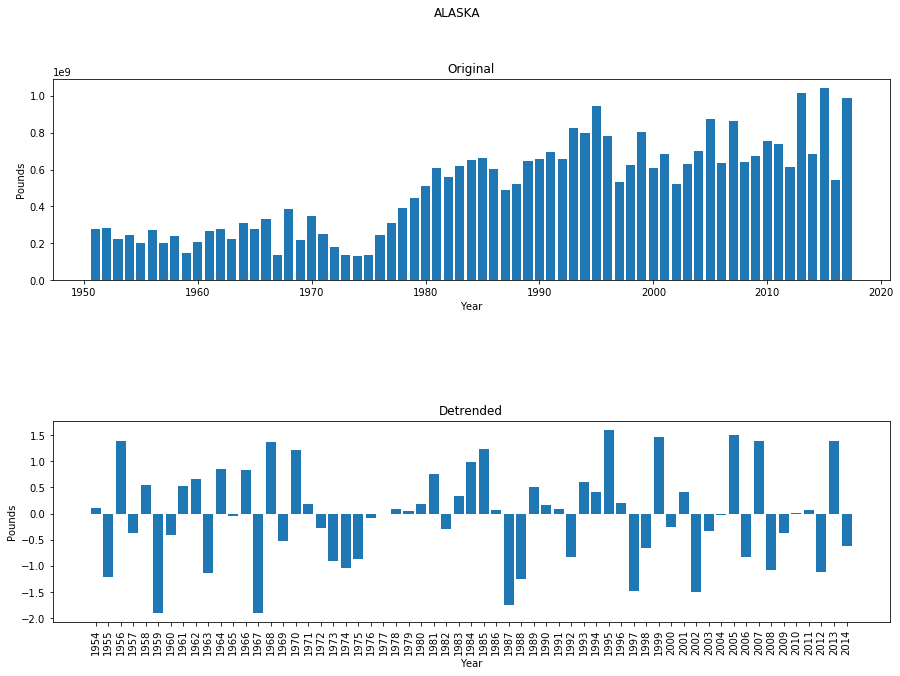

In [15]:
prod_plot("ALASKA")

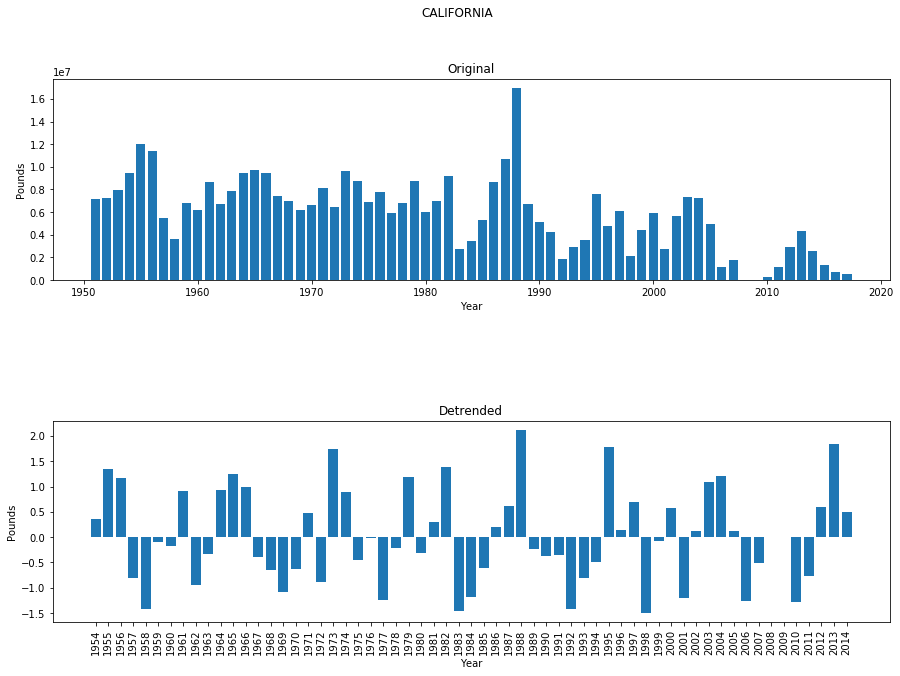

In [16]:
prod_plot("CALIFORNIA")

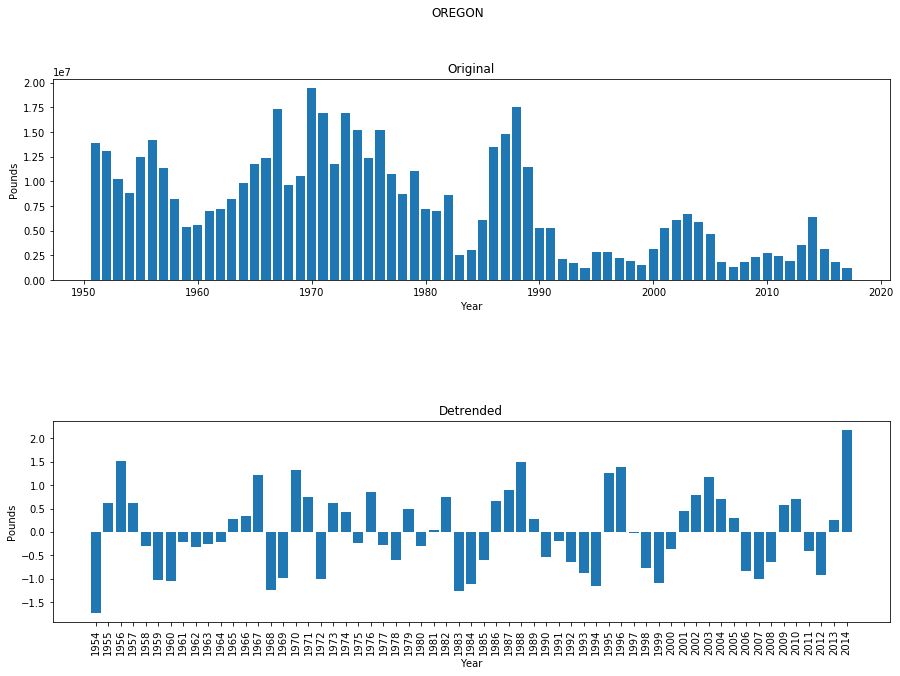

In [17]:
prod_plot("OREGON")

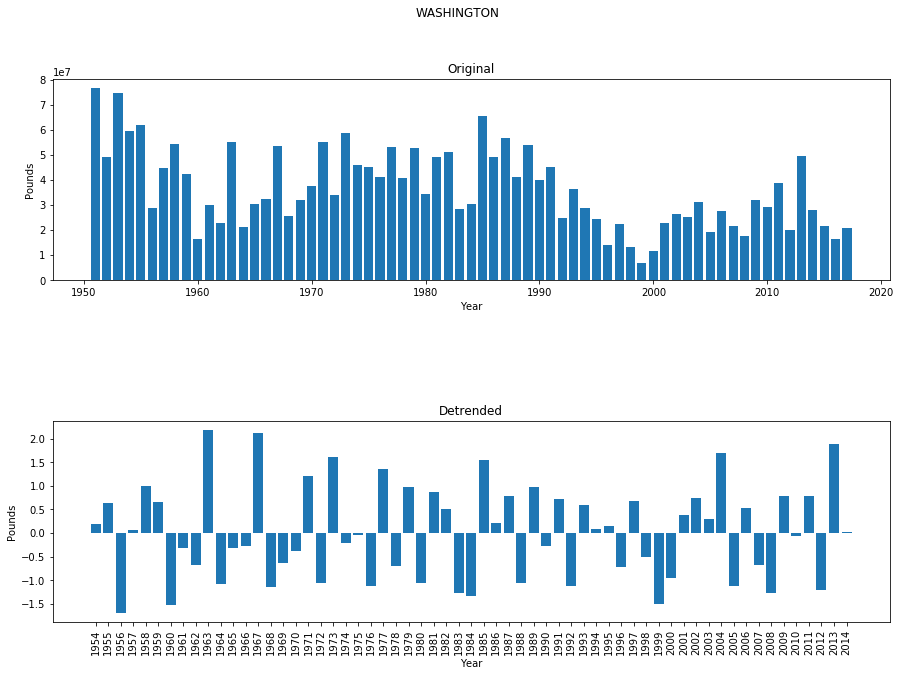

In [18]:
prod_plot("WASHINGTON")

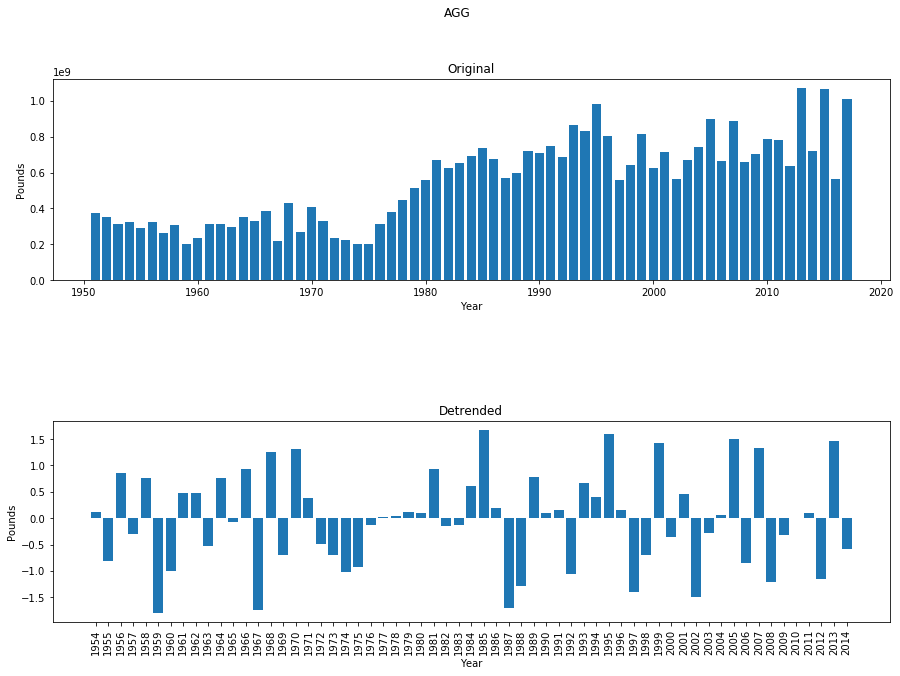

In [19]:
prod_plot("AGG")

## Part A - Macro Environment Indicators

There are 3 global indicators that I want to examine: Sea Surface Temperature (SST), ENSO index, and NINO 3.4 Index

### I. SEA SURFACE TEMPERATURE (SST)
_Global Sea Surface Temperature from 1865 - 2017_

This dataset comes in as monthly values of global Sea Surface Temperature. In order to convert that to a series of annual value, I take the average value of December from the previous year and January and Feburary of current year, and use it as the value for the whole year. This data calculation is supported by research into Salmon life cycle, which states that sea temperature in the Winter is most important to the reproduction of Salmon. 

In [20]:
# SST | average sea tempreature

nc_f = 'data/sst.mnmean.nc'  # Your filename
nc_fid = Dataset(nc_f, 'r', format='NETCDF4') 

 # extract/copy the data
latitude = nc_fid.variables['lat'][:] 
longitude = nc_fid.variables['lon'][:]
time = nc_fid.variables['time'][:]
sst = nc_fid.variables['sst'][:] 


# Convert time array to actual date
start = dt.date(1800, 1, 1)

# List of all times in the file as datetime objects
dt_time = [start + dt.timedelta(days=t) for t in time]


In [21]:
# Calculate yearly average sea tempreature
yearly_sst_avg_3m = []
yearly_sst_avg_12m = []

for start_idx in range(12, len(dt_time), 12):
    
    year = dt_time[start_idx].year
    # get data from Dec (last year), Jan, Feb
    
    year_sst_3m = sst[start_idx-1:start_idx+2,:,:]
    year_sst_12m = sst[start_idx:start_idx+12,:,:]
    
    month, lat_len, long_len = year_sst_3m.shape

    year_avg_3m = np.zeros([lat_len, long_len])
    year_avg_12m = np.zeros([lat_len, long_len])

    for i in range(lat_len):
        for j in range(long_len):
            year_avg_3m[i, j] = np.mean(year_sst_3m[:, i, j])
            year_avg_12m[i, j] = np.mean(year_sst_12m[:, i, j])
            
            
    yearly_sst_avg_3m.append([year, year_avg_3m])
    yearly_sst_avg_12m.append([year, yearly_sst_avg_12m])
    
yearly_sst_avg = yearly_sst_avg_3m

len_x, len_y = yearly_sst_avg[0][1].shape

/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.
/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Warning: converting a masked element to nan.


In [22]:
yearly_sst_avg_scaled = []

for year, yearly_sst_data_tmp in yearly_sst_avg:
    yearly_sst_data_scaled = yearly_sst_data_tmp.copy()

    flat_year_sst = np.array([item for sublist in yearly_sst_data_tmp for item in sublist if str(item) != 'nan'])

    sst_scaler = StandardScaler()

    sst_scaler.fit(flat_year_sst.reshape(-1, 1))


    for i in range(len_x):
        for j in range(len_y):
            sst_val_tmp = yearly_sst_data_tmp[i][j]
            scaled_val_tmp = sst_scaler.transform(np.array(sst_val_tmp).reshape(-1, 1))[0][0]
            yearly_sst_data_scaled[i][j] = scaled_val_tmp
    yearly_sst_avg_scaled.append([year, yearly_sst_data_scaled])

Option to use standardized or absolute SST values

In [23]:
use_scaled_sst = False

if use_scaled_sst:
    yearly_sst_avg = yearly_sst_avg_scaled
else:
    yearly_sst_avg = yearly_sst_avg_3m

In [24]:
def draw_with_basemap(data, title = '', color_bar = True, con_plot = True):
    # START HERE

    m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='cyl')

    # covert the latitude and longitude to raster coordinates to be plotted
    t1 = data
#     t1, lon = addcyclic(t1, longitude)
    sst_data_map, lons = shiftgrid(180., t1, longitude, start=False)
    x,y  = np.meshgrid(lons,latitude)
    px,py = m(x,y)

    # create the global map and save it as a png file
    rcParams['font.size'] = 12
    rcParams['figure.figsize'] = [8.0, 6.0]
    palette = cm.RdYlBu_r

    figure()

    m.drawcoastlines(linewidth=0.5)
    m.drawmapboundary(fill_color=(1.0,1.0,1.0))
    
    if con_plot:
        cf=m.contourf(px, py, sst_data_map, cmap = palette)
    else:
        cf=m.pcolor(px, py, sst_data_map, cmap = palette)
    if color_bar:
        cbar = colorbar(cf,orientation='horizontal', shrink=0.95)
        
    plt.title(title)

    tight_layout()
    
    plt.show()

A look of what the SST data look like in a given year

/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


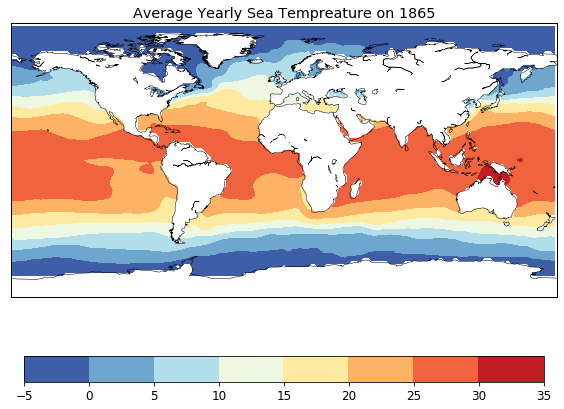

In [25]:
year_idx = 10

draw_with_basemap(yearly_sst_avg[year_idx][1], 
                  title = "Average Yearly Sea Tempreature on %d" % yearly_sst_avg[year_idx][0])

### 1. Superposed Epoch Analysis (SEA)


Superposed epoch analysis (SPE or SEA), also called Chree analysis, is a statistical tool to detect periodicities within a time sequence or to reveal a correlation (usually in time) between two data sequences (usually two time series)  
<br>
In using this analysis, I break down the Salmon productions are broken into two groups:
- High production years: 95th percentile  
- Low production years: 5th percentile  

The sea surface temperature value for each group is then calculated as the average value of all the years in that group. What I am hope to uncover is difference in patterns in SST between the two groups. Because Salmon's preferred environment is cold, I expect the SST during high production years to be less than the SST during low production years

In [101]:
def extreme_year_report(state, lower_q = 0.05, upper_q = 0.95):
    de_lower_quantile = detrend_prod_df[state].quantile(lower_q)
    de_upper_quantile = detrend_prod_df[state].quantile(upper_q)

    year_lst_lower_quantile = detrend_prod_df[detrend_prod_df[state] < de_lower_quantile]["Year"].values

    year_lst_upper_quantile = detrend_prod_df[detrend_prod_df[state] > de_upper_quantile]["Year"].values

    print(state)
    print("%dth percentile years" % int(lower_q*100))
    print(year_lst_lower_quantile)
    print("%dth percentile years" % int(upper_q*100))
    print(year_lst_upper_quantile)
    
    return [year_lst_lower_quantile, year_lst_upper_quantile]

state_lst = ['ALASKA', 'CALIFORNIA', 'OREGON', 'WASHINGTON', 'AGG']
state_extreme_dict = {}
for state in state_lst:
    state_extreme_dict[state] = extreme_year_report(state)


ALASKA
5th percentile years
[1959 1967 1987]
95th percentile years
[1995 1999 2005]
CALIFORNIA
5th percentile years
[1958 1983 1998]
95th percentile years
[1988 1995 2013]
OREGON
5th percentile years
[1954 1968 1983]
95th percentile years
[1956 1988 2014]
WASHINGTON
5th percentile years
[1956 1960 1999]
95th percentile years
[1963 1967 2013]
AGG
5th percentile years
[1959 1967 1987]
95th percentile years
[1985 1995 2005]


In [27]:
def plot_extreme_year(state):
#     year_lst_lower_quantile, year_lst_upper_quantile
    year_lst_lower_quantile, year_lst_upper_quantile = state_extreme_dict[state] 

    year_sst_of_interest_lower_quantile = [d for d in yearly_sst_avg if d[0] in year_lst_lower_quantile]
    year_sst_of_interest_upper_quantile = [d for d in yearly_sst_avg if d[0] in year_lst_upper_quantile]


    # Initialize

    state_extreme_lower_quantile = np.zeros([len_x, len_y])
    state_extreme_upper_quantile = np.zeros([len_x, len_y])

    for i in range(len_x):
        for j in range(len_y):

            sst_data_lower_quantile = []
            sst_data_upper_quantile = []

            # collect sst data
            for year, data in year_sst_of_interest_lower_quantile:
                sst_data_lower_quantile.append(data[i,j])

            for year, data in year_sst_of_interest_upper_quantile:
                sst_data_upper_quantile.append(data[i,j])

            try:
                state_extreme_lower_quantile[i][j] = np.mean(sst_data_lower_quantile)
            except:
                print(i, '-', j)

            try:
                state_extreme_upper_quantile[i][j] = np.mean(sst_data_upper_quantile)
            except:
                print(i, '-', j)


    draw_with_basemap(state_extreme_lower_quantile, title = "%s Average of 5th percentile group" % state, con_plot = True)

    draw_with_basemap(state_extreme_upper_quantile, title = "%s Average of 95th percentile group" % state, con_plot = True)

#### Results 1
<br>
Upon examining the visualizations between the two group, for both individual states and aggregate data, it is clear that the Sea is warmer during the low production years, and is colder during the high production years. This is consistent with the understanding of Salmon habitat

/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


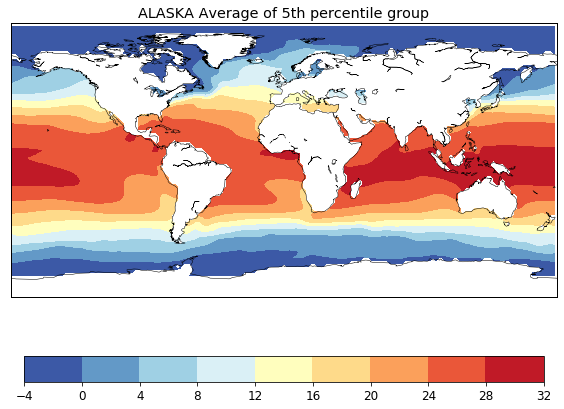

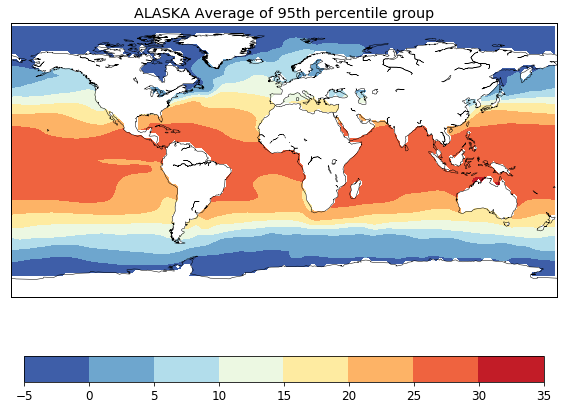

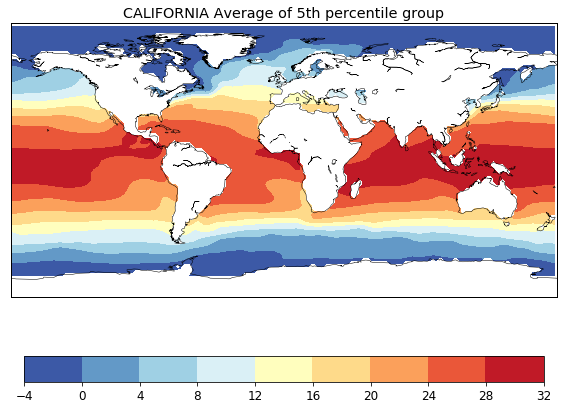

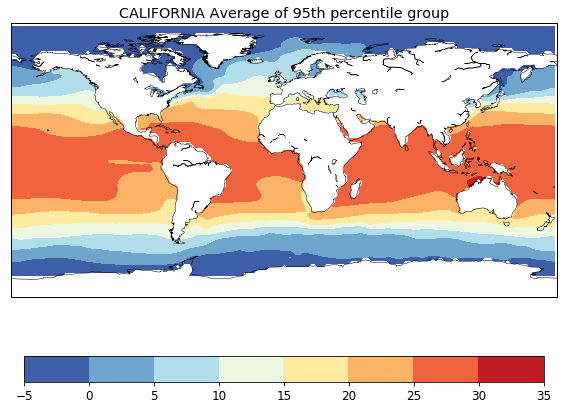

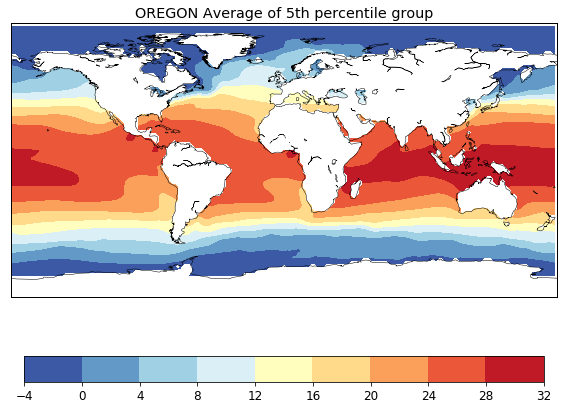

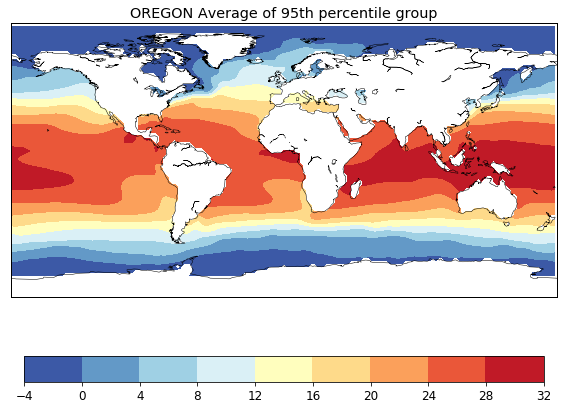

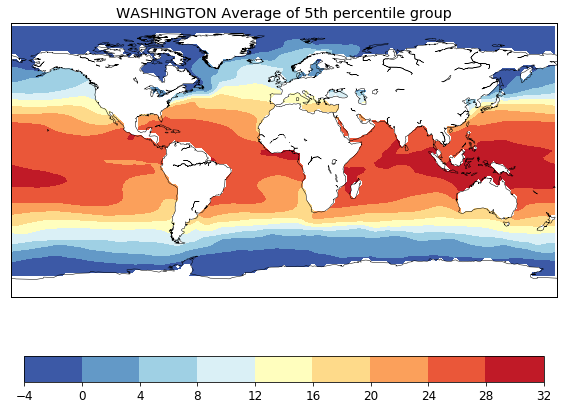

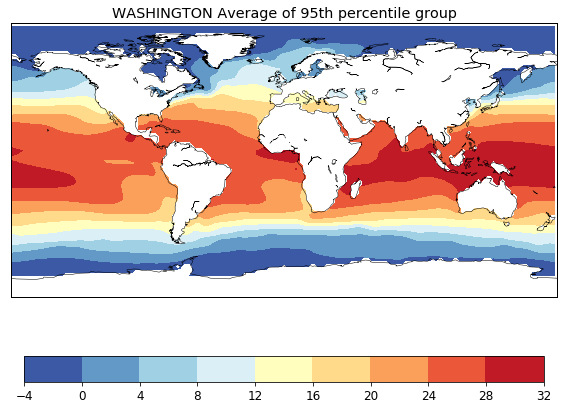

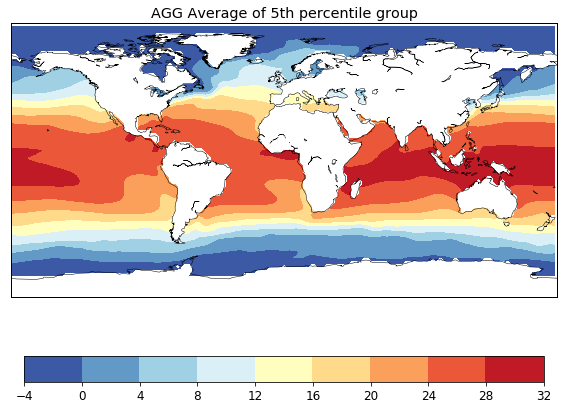

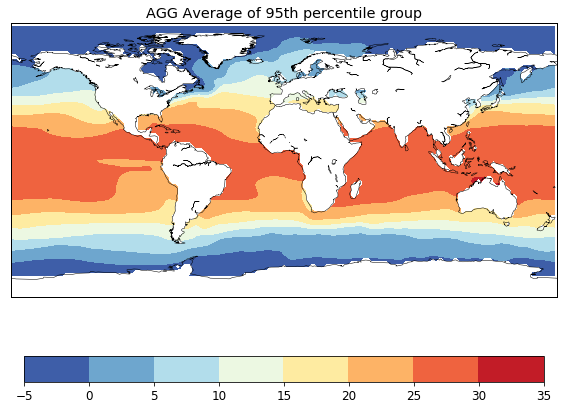

In [28]:
state_lst = ['ALASKA', 'CALIFORNIA', 'OREGON', 'WASHINGTON', 'AGG']
for state in state_lst:
    plot_extreme_year(state)

### 2. SST Correlation map: An analysis of El Nino & La Nina
<br>
The North West sea where Salmon are caught in the U.S. might be heavily influenced by natural phenomenon that happen globally. Many researches have pointed to El Niño and La Niña as the major causes of variation in climate factors. El Niño and La Niña are opposite phases of what is known as the El Niño-Southern Oscillation (ENSO) cycle, which describes the fluctuations in temperature between the ocean and atmosphere in the east-central Equatorial Pacific (approximately between the International Date Line and 120 degrees West).    
<br>  <br>
The term El Niño refers to the large-scale ocean-atmosphere climate interaction linked to a periodic warming in sea surface temperatures across the central and east-central Equatorial Pacific. Meanwhile, La Niña episodes represent periods of below-average sea surface temperatures across the east-central Equatorial Pacific. Global climate La Niña impacts tend to be opposite those of El Niño impacts. In the tropics, ocean temperature variations in La Niña also tend to be opposite those of El Niño.
<br>  <br>
In this analysis, I will determine which areas of the global sea have the highest correlation with the Salmon production, and see whether a similar patterns to El Nino & La Nina would emerge

In [29]:
year_lag = 1

# INPUT
yearly_sst_main = yearly_sst_avg[99-year_lag:160-year_lag]
yearly_sst_main_for_detrend = yearly_sst_avg[98-year_lag - 3:160-year_lag + 3] # detrend with 3 years

# OUTPUT
de_a = detrend_prod_df['ALASKA']
de_c = detrend_prod_df['CALIFORNIA']
de_o = detrend_prod_df['OREGON']
de_w = detrend_prod_df['WASHINGTON']
de_agg = detrend_prod_df['AGG']

input_year_min, input_year_max =  yearly_sst_main[0][0], yearly_sst_main[-1][0]
output_year_min, output_year_max = min(detrend_prod_df["Year"]), max(detrend_prod_df["Year"]) 

print("INPUT Year range: %d - %d" % (yearly_sst_main[0][0], yearly_sst_main[-1][0]) )
print("OUTPUT Year range: %d - %d" % (min(detrend_prod_df["Year"]), max(detrend_prod_df["Year"]) ))

INPUT Year range: 1953 - 2013
OUTPUT Year range: 1954 - 2014


In [30]:
# Collect the sea tempreature over the year for every coordinate 
len_x, len_y = yearly_sst_main[0][1].shape

processed_sst_data = [ [{'original' : [], 'detrend' : []} for x in range(len_y) ] 
                      for y in range(len_x) ]

for i in range(len_x):
    for j in range(len_y):

        sst_data = []
        
        # original sst
        for year, data in yearly_sst_main:
            sst_data.append(data[i,j])
        
        detrend_sst_data = []
        
        # detrend sst
        for year, data in yearly_sst_main_for_detrend:
            detrend_sst_data.append(data[i,j])
        
        detrend_sst_data = detrend(sst_data)
        
        try:
            processed_sst_data[i][j] = {'original' : sst_data, 'detrend' : detrend_sst_data}
        except:
            print(i, '-', j)

In [31]:
def plot_sst_corr_map(fish_data, yearly_sst_data = processed_sst_data, title = "", detrend_sst = False,
                      corr_tol = 0.1, p_toll = 0.9):
    print("OUTPUT production data for %s with %d-year lag" % (title, year_lag) )
    # Map 0 - not filtered 
    len_x = len(yearly_sst_data)
    len_y = len(yearly_sst_data[0])

    corr_mat = np.zeros([len_x, len_y])
    p_mat = np.zeros([len_x, len_y])
    if detrend_sst:
        fish_data = fish_data[3:-3]
        
    for i in range(len_x):
        for j in range(len_y):

            tmp_data = []
            
            # detrend sst
            if detrend_sst:
                sst_data = yearly_sst_data[i][j]['detrend']
            else:
                sst_data = yearly_sst_data[i][j]['original'] 
            try:
                corr, p_value = pearsonr(sst_data, fish_data)
                corr_mat[i, j] = corr
                p_mat[i, j] = p_value
            except Exception as e:
                corr_mat[i, j] = np.NaN
                p_mat[i, j] = np.NaN
    
#     draw_with_basemap(corr_mat, title = 'Correlation Heat map') 
#     draw_with_basemap(p_mat, title = 'P-Value')

    # Summary data

    max_corr_pos = [0, 0]
    max_corr = -2

    min_p_pos = [0, 0]
    min_p = 10

    for i in range(len_x):
        for j in range(len_y):
            pos = [i, j]
            corr_val = abs(corr_mat[pos[0], pos[1]])
            p_val = p_mat[pos[0], pos[1]]

            if(np.isnan(corr_val) or np.isnan(p_val)):
                continue

            if corr_val > max_corr:
                max_corr_pos = pos
                max_corr = corr_val

            if p_val < min_p:
                min_p_pos = pos
                min_p = p_val
                
    
    # Map 1 - filtered data
    corr_cutoff = max_corr*(1-corr_tol)
    p_cutoff = min_p*(1+p_toll)

    corr_mat_filtered = np.zeros([len_x, len_y])
    p_mat_filtered = np.zeros([len_x, len_y])

    sig_p_index = []
    
    for i in range(len_x):
        for j in range(len_y):
            corr_val = abs(corr_mat[i, j])
            p_val = p_mat[i, j]

            if(np.isnan(corr_val) or np.isnan(p_val)):
                corr_mat_filtered[i, j] =  np.NaN
                p_mat_filtered[i, j] =  np.NaN
            else:
                if corr_val < corr_cutoff:
                    corr_mat_filtered[i, j] = 0
                else:
                    corr_mat_filtered[i, j] = 30

                if p_val > 0.1: #p_cutoff:
                    p_mat_filtered[i, j] = np.NaN
                else:
                    p_mat_filtered[i, j] = 50
                    sig_p_index.append([i, j])
    
    p_mat_filtered[0, 0] = 0
    p_mat_filtered[0, 1] = 100
#     draw_with_basemap(corr_mat_filtered, title = 'Correlation Heat map (Significant Area)\nArea with high correlation - max_corr: %.3f' % max_corr, color_bar = False)
#     draw_with_basemap(p_mat_filtered, title = 'P-Value (Significant Area)\nArea with low p-value', color_bar = False)
    
    print("Max correlation is %.6f at [%d, %d] " % (max_corr, max_corr_pos[0], max_corr_pos[1]))
    print("Min p-value is %.6f at [%d, %d] " % (min_p, min_p_pos[0], min_p_pos[1]))

    
    # START HERE

    m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='cyl')

    # covert the latitude and longitude to raster coordinates to be plotted
    t1 = corr_mat
    sst_data_map1, lons = shiftgrid(180., t1, longitude, start=False)
    
    sig_p_lon = []
    sig_p_lon1 = []
    sig_p_lat = []
    # GET THE COORDINATES
    for i in range(len_x):
        for j in range(len_y):
            p_val = p_mat[i, j]
            if p_val < 0.1:
                sig_p_lon.append(longitude[j])
                sig_p_lon1.append(lons[j])
                sig_p_lat.append(latitude[i])
        
                    
    t2 = p_mat_filtered
    sst_data_map2, lons123 = shiftgrid(180., t2, longitude, start=False)
    
    # map 1 
    x,y  = np.meshgrid(lons,latitude)
    px,py = m(x,y)
    
    # map 2
    sig_p_lon1 = [v - 180 for v in sig_p_lon1]
#     print(px_p)
    # create the global map and save it as a png file
    rcParams['font.size'] = 10
    rcParams['figure.figsize'] = [8.0, 6.0]
    rcParams['lines.markersize'] = 1
    palette = cm.RdYlBu_r

    figure()

    m.drawcoastlines(linewidth=0.5)
    m.drawmapboundary(fill_color=(1.0,1.0,1.0))
    

    cf = m.contourf(px, py, sst_data_map1, cmap = cm.RdYlBu_r)
    colorbar(cf,orientation='horizontal', shrink=0.95)
    
    marker_col = 'm'
    m.scatter(sig_p_lon, sig_p_lat, marker='.', color=marker_col , alpha = 0.6)
    m.scatter(sig_p_lon1, sig_p_lat, marker='.', color=marker_col , alpha = 0.6)
    
#     m.pcolormesh(px, py, sst_data_map2, cmap = 'plasma', alpha = 0.2)
    
        
    plt.title("Correlation and Significant P-val Overlay for %s" % title)

    tight_layout()
    
    plt.show()
    
# plot_sst_corr_map(detrend_prod_df['ALASKA'], title = "ALASKA")

**Results**  
The correlation map between Salmon landings and global Sea Surface Temperature reveals areas of high correlation with significant p-value _near the equator_ and _south of the Pacific Ocean_. This finding is consistence with the patterns of El Nino & La Nina, the two major periodic ocean-atmosphere phenomenon involving changes in the temperature of waters of the Pacific Ocean.
<br>
<img src="files/NinoNina.png">

##### ALASKA

OUTPUT production data for ALASKA with 1-year lag


/Users/Tung/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Max correlation is 0.455071 at [68, 141] 
Min p-value is 0.000229 at [68, 141] 


/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


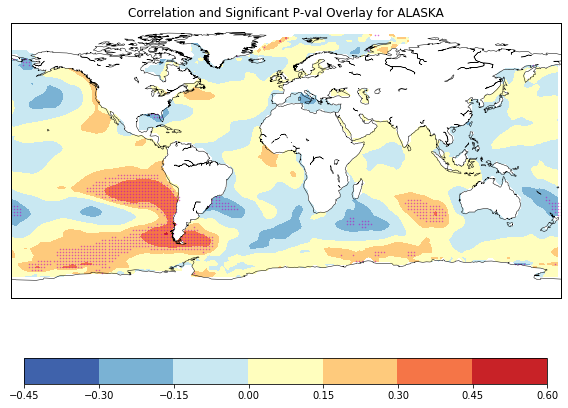

In [32]:
plot_sst_corr_map(detrend_prod_df['ALASKA'], title = "ALASKA")

##### OREGON

OUTPUT production data for OREGON with 1-year lag
Max correlation is 0.341657 at [36, 21] 
Min p-value is 0.007042 at [36, 21] 


/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


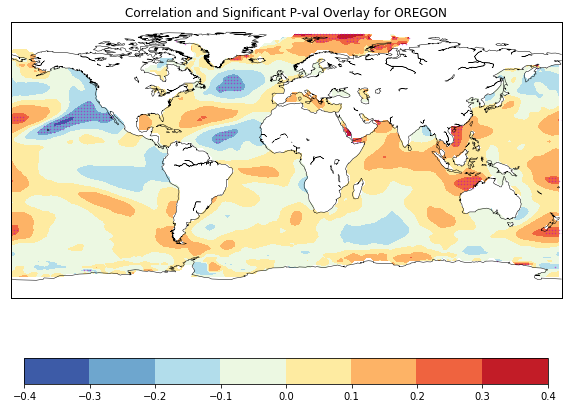

In [33]:
plot_sst_corr_map(de_o, title = "OREGON", corr_tol = 0.1, p_toll = 0.9)

##### CALIFORNIA

OUTPUT production data for CALIFORNIA with 1-year lag
Max correlation is 0.441540 at [24, 90] 
Min p-value is 0.000831 at [24, 90] 


/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


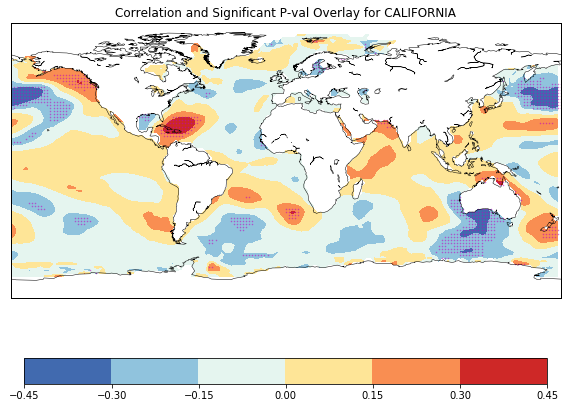

In [34]:
# cali has the last 7 years unusable due to missing data
# Collect the sea tempreature over the year for every coordinate 
len_x, len_y = yearly_sst_main[0][1].shape

processed_sst_data_cali = [ [{'original' : [], 'scaled' : [], 'detrend' : []} for x in range(len_y) ] 
                      for y in range(len_x) ]

for i in range(len_x):
    for j in range(len_y):
        processed_sst_data_cali[i][j] = {'original' : processed_sst_data[i][j]['original'][:-7], 
                                         'detrend' : processed_sst_data[i][j]['detrend'][:-7]}
        
# Washington
plot_sst_corr_map(de_c[:-7], processed_sst_data_cali,title = "CALIFORNIA")

##### WASHINGTON

OUTPUT production data for WASHINGTON with 1-year lag
Max correlation is 0.334411 at [79, 11] 
Min p-value is 0.008436 at [79, 11] 


/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


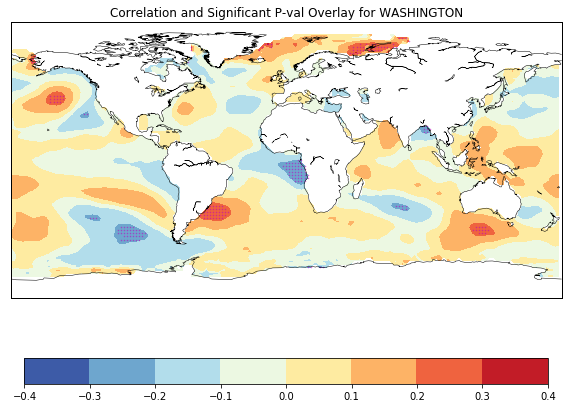

In [35]:
plot_sst_corr_map(de_w, title = "WASHINGTON")

##### AGGREGATE 

OUTPUT production data for AGGREGATE with 1-year lag
Max correlation is 0.450693 at [68, 141] 
Min p-value is 0.000267 at [68, 141] 


/Users/Tung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


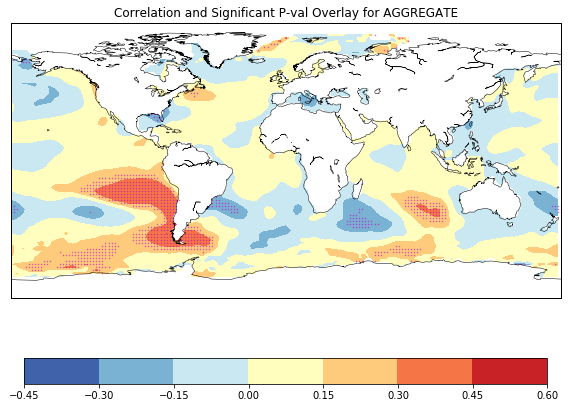

In [36]:
plot_sst_corr_map(de_agg, title = "AGGREGATE", detrend_sst = False)

In [37]:
rcParams['lines.markersize'] = 5

### II. Multivariate El Niño/Southern Oscillation (ENSO) Index

_ENSO Index from 1979 - 2017_

The second global indicator that I want to analyze is ENSO Index. The ENSO index is the time series of the leading combined Empirical Orthogonal Function (EOF) of five different variables (sea level pressure (SLP), sea surface temperature (SST), zonal and meridional components of the surface wind, and outgoing longwave radiation (OLR)) over the tropical Pacific basin. The EOFs are calculated for 12 overlapping bi-monthly "seasons" (Dec-Jan, Jan-Feb, Feb-Mar,..., Nov-Dec) in order to take into account ENSO's seasonality, and reduce effects of higher frequency intraseasonal variability. 
  <br> <br>
Positive ENSO index correlates to El Nino period and negative ENSO index correlates to La Nina period. Therefore, I expect Salmon production to have a negative correlation with this index.   


In [38]:
f = open("meiv2.data")
enso_idx = f.read()

enso_data = [r.split() for r in enso_idx.split('\n')]
enso_data = enso_data[0:-6]


enso_dict = {}
for i in enso_data:
    enso_dict[i[0]] = list(map(float, i[1:]))
    
    
enso_df = pd.DataFrame(enso_dict).T

enso_all = [item for sublist in enso_dict.values() for item in sublist] 

enso_year = list(enso_dict.keys())
yearly_enso_data = [np.mean(e_lst) for e_lst in enso_dict.values()]
yearly_enso_data_detrend = detrend(yearly_enso_data)

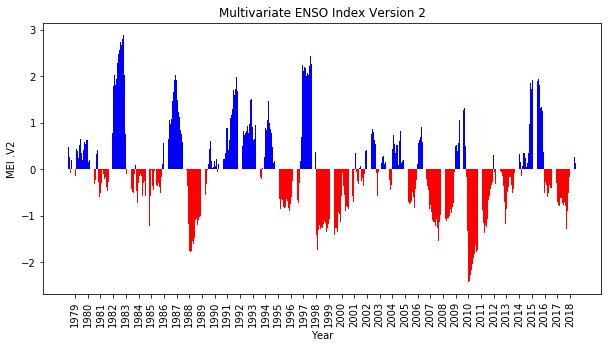

In [39]:
enso_col = ['r' if i < 0 else 'b' for i in enso_all]

plt.figure(figsize=(10, 5))

enso_len = len(enso_all)
plt.bar(range(enso_len), enso_all, color = enso_col)

plt.xlabel("Year")
plt.ylabel("MEI .V2")

plt.title("Multivariate ENSO Index Version 2")

plt.xticks(range(6,enso_len, 12), enso_year, rotation=90)

plt.show()

In [40]:
# enso yearly data as average of 3 months start at 1980
plt.figure(figsize=(10, 5))
enso_year = list(enso_dict.keys())[1:]

enso_lst = list(enso_dict.values())
yearly_enso_data = []
for i, v in enumerate(enso_lst):
    if i == 0:
        pass
    else:
        enso_year_tmp = [enso_lst[i-1][-1], v[0], v[1]]
        yearly_enso_data.append(np.mean(enso_year_tmp))
  
# yearly_enso_data_detrend = detrend(yearly_enso_data)

<Figure size 720x360 with 0 Axes>

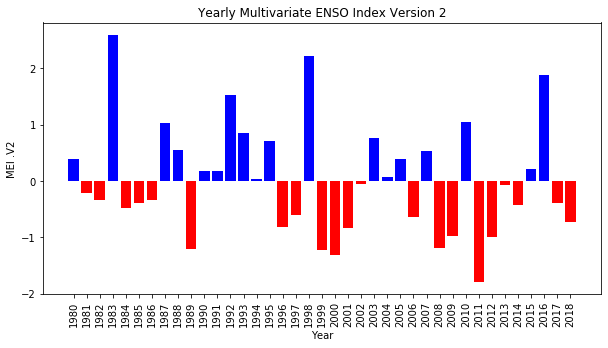

In [41]:
plt.figure(figsize=(10, 5))

enso_col_o = ['r' if v < 0 else 'b' for v in yearly_enso_data]
plt.bar(enso_year, yearly_enso_data, color = enso_col_o)

plt.xlabel("Year")
plt.ylabel("MEI .V2")

plt.title("Yearly Multivariate ENSO Index Version 2")

plt.xticks(range(len(enso_year)), enso_year, rotation=90)

plt.show()

In [42]:
enso_df = pd.DataFrame(zip(enso_year, yearly_enso_data), columns =["Year", "MEI .V2"])
enso_df['Year'] = enso_df['Year'].astype(int)

lag = 0

max_year = min(max(detrend_prod_df["Year"]), max(enso_df["Year"]))
min_year = max(min(detrend_prod_df["Year"]), min(enso_df["Year"]))

prod_year_range = [min_year+lag, max_year]
enso_year_range = [min_year, max_year-lag]

detrend_prod_df_w_lag = detrend_prod_df[ (prod_year_range[0] <= detrend_prod_df["Year"]) 
                                        & (detrend_prod_df["Year"] <= prod_year_range[1])]

enso_df_w_lag = enso_df[ (enso_year_range[0] <= enso_df["Year"]) 
                                        & (enso_df["Year"] <= enso_year_range[1])]

print("Year Range: %d - %d"%(min_year, max_year))
print("Production year range", prod_year_range)
print("Enso year range", enso_year_range)

Year Range: 1980 - 2014
Production year range [1980, 2014]
Enso year range [1980, 2014]


In [43]:
def enso_plot(state):
    plt.figure(figsize=(10,5))
    
    fish_data = detrend_prod_df_w_lag[state]
    enso_data = enso_df_w_lag['MEI .V2']

    r_sq, p_val = pearsonr(enso_data, fish_data)

    plt.scatter(enso_data, fish_data)


    plt.xlabel("MEI .V2")
    plt.ylabel("Pounds")

    plt.title("%s with lag %d \n Pearson Correlation: r_sq = %.3f p = %.3f"%(state, lag, r_sq, p_val))

    plt.show()


***Results***
<br>
When plotting the two time series side by side, ENSO index and production data doesn’t show a strong correlation. As stated previously, a positive ENSO value should indicate a negative production output, and vice versa. In this case, only some cycles of production are explained by ENSO values.
<br> <br>

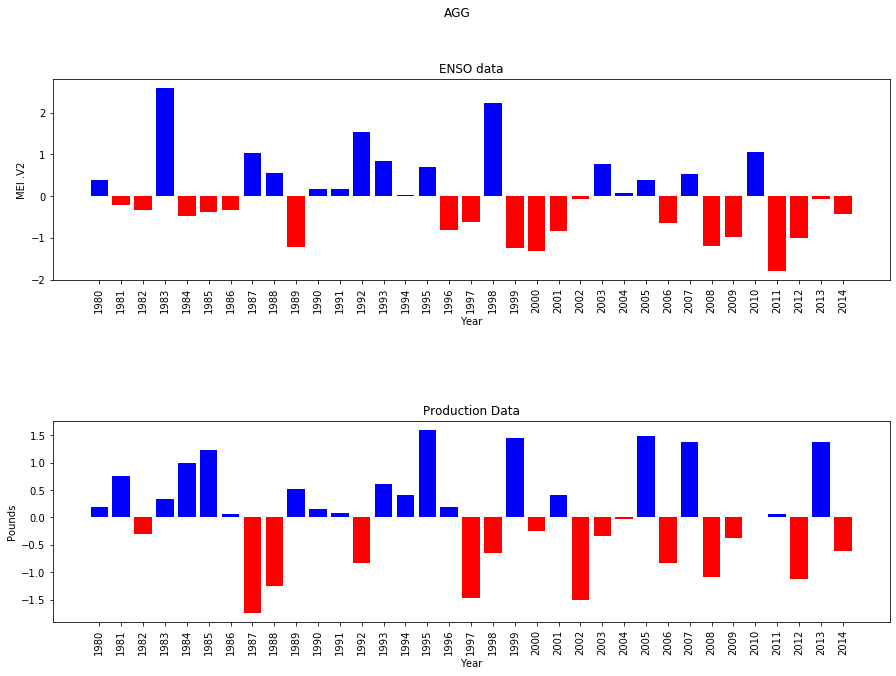

In [49]:
def enso_bar(state):
    
    fish_data = detrend_prod_df_w_lag['ALASKA'].values
    fish_year = detrend_prod_df_w_lag['Year'].values
    fish_col = ['r' if v < 0 else 'b' for v in fish_data]

    enso_data = enso_df_w_lag['MEI .V2'].values
    enso_year = enso_df_w_lag['Year'].values
    enso_col = ['r' if v < 0 else 'b' for v in enso_data]

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    fig.subplots_adjust(wspace=0.7, hspace=0.7)
    
    axes[1].bar(fish_year, fish_data, color = fish_col, align='center')
    axes[0].bar(enso_year, enso_data, color = enso_col)
    
    axes[1].title.set_text('Production Data')
    axes[0].title.set_text('ENSO data')
    
    axes[1].set_xlabel("Year")
    axes[1].set_ylabel("Pounds")
    
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("MEI .V2")

    axes[1].xaxis.set_ticks(fish_year)
    axes[0].xaxis.set_ticks(enso_year)
    
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)
        
    for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)

    fig.suptitle(state)

    plt.show()
    
# state_lst = ['ALASKA', 'CALIFORNIA', 'OREGON', 'WASHINGTON', 'AGG']
state_lst = ['AGG']
for state in state_lst:
    enso_bar(state)

### III. NINO 3.4 Index

_NINO index from 1950 - 2017_

The third and last global indicator I want to analyze is the NINO Index. The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast.  The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.
<br> <br>
With NINO Index, I'm hoping to see a similar relationship with Salmon production data. Specifically, for a positive NINO index I expect to see a negative production data, and vice versa.

In [50]:
f = open("data/nina34.data")
nino34 = f.read()

nino34_data = [r.split() for r in nino34.split('\n')]
nino34_data = nino34_data[3:-6]

nino34_dict = {}

for i in nino34_data:
    nino34_dict[i[0]] = list(map(float, i[1:]))

nino34_df = pd.DataFrame(nino34_dict).T

nino34_all = [item for sublist in nino34_dict.values() for item in sublist] 

nino_year = nino34_df.index

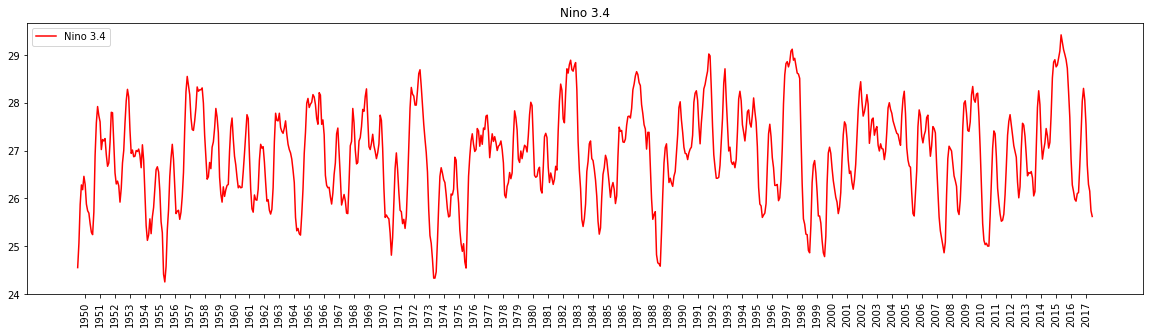

In [51]:
plt.figure(figsize=(20, 5))

plt.plot(nino34_all, label = "Nino 3.4", color ='r')
# plt.plot(nino4_all, label = "Nino 4", color ='b')


plt.title("Nino 3.4")

nino34_len = len(nino34_all)

plt.xticks(range(6,nino34_len, 12), nino_year, rotation=90)
plt.legend()
plt.show()

In [52]:
# NINO yearly data as average of 3 months start at 1951
nino_year = list(nino34_dict.keys())[1:]

# nino 3.4
nino34_lst = list(nino34_dict.values())

yearly_nino34_data = []
for i, v in enumerate(nino34_lst):
    if i == 0:
        pass
    else:
        year_tmp_data = [nino34_lst[i-1][-1], v[0], v[1]]
        yearly_nino34_data.append(np.mean(year_tmp_data))
        
# yearly_nino34_data_detrend = detrend(yearly_nino34_data)

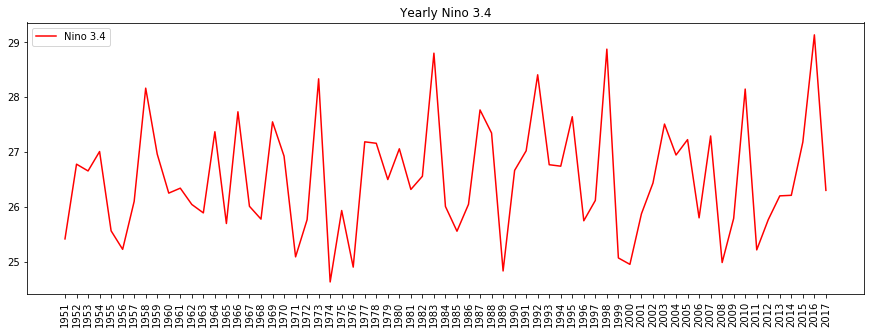

In [83]:
plt.figure(figsize=(15,5))
plt.plot(nino_year, yearly_nino34_data, color = 'r', label = "Nino 3.4")

plt.legend()
plt.title("Yearly Nino 3.4")

plt.xticks(range(len(nino_year)), nino_year, rotation=90)

plt.show()

In [54]:
nino34_df = pd.DataFrame(zip(nino_year, yearly_nino34_data), columns =["Year", "Val"])
nino34_df['Year'] = nino34_df['Year'].astype(int)

nino_scaler = StandardScaler()
nino34_df["scaled_val"] = nino_scaler.fit_transform(nino34_df["Val"].values.reshape(-1, 1))

# detrend_nino4_df = pd.DataFrame(zip(nino_year[3:-3], yearly_nino4_data_detrend), columns =["Year", "Val"])
# detrend_nino4_df['Year'] = detrend_nino4_df['Year'].astype(int)


lag = 0

max_year = min(max(detrend_prod_df["Year"]), max(nino34_df["Year"]))
min_year = max(min(detrend_prod_df["Year"]), min(nino34_df["Year"]))

prod_year_range = [min_year+lag, max_year]
nino_year_range = [min_year, max_year-lag]

detrend_prod_df_w_lag = detrend_prod_df[ (prod_year_range[0] <= detrend_prod_df["Year"]) 
                                        & (detrend_prod_df["Year"] <= prod_year_range[1])]

nino34_df_w_lag = nino34_df[ (nino_year_range[0] <= nino34_df["Year"]) 
                                        & (nino34_df["Year"] <= nino_year_range[1])]

# detrend_nino4_df_w_lag = detrend_nino4_df[ (nino_year_range[0] <= detrend_nino4_df["Year"]) 
#                                         & (detrend_nino4_df["Year"] <= nino_year_range[1])]

print("Year Range: %d - %d"%(min_year, max_year))
print("Production year range", prod_year_range)
print("Nino year range", nino_year_range)

Year Range: 1954 - 2014
Production year range [1954, 2014]
Nino year range [1954, 2014]


**Results**

As seen previously with the ENSO Index, the NINO 3.4 Index proves to be unhelpful as a predictive indicator for the Salmon production in the U.S. Some fluctuations in production cycles are explained by the movement of NINO index. However, not all of them are.

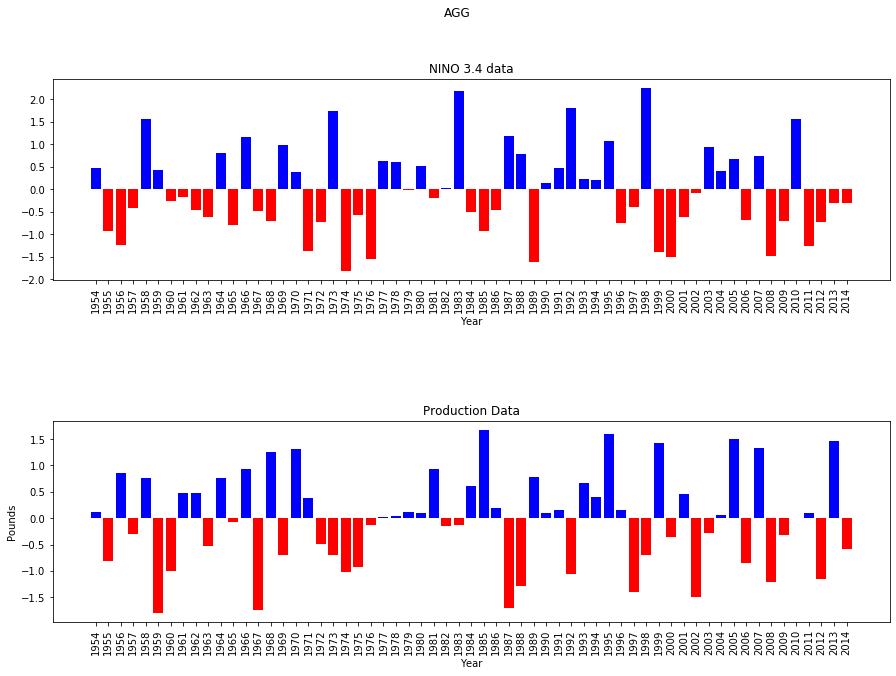

In [80]:
def nino_bar(state, use_scaled_data = True):
    if use_scaled_data:
        nino34_col_name = 'scaled_val'
    else:
        nino34_col_name = 'Val'
        
        
    fish_data = detrend_prod_df_w_lag[state]
    fish_data = detrend_prod_df_w_lag[state]
    fish_year = detrend_prod_df_w_lag['Year'].values
    fish_col = ['r' if v < 0 else 'b' for v in fish_data]

    nino34_data = nino34_df_w_lag[nino34_col_name].values
    nino34_year = nino34_df_w_lag['Year'].values
    nino34_col = ['r' if v < 0 else 'b' for v in nino34_data]
        
#     nino4_data = detrend_nino4_df_w_lag["Val"].values 
#     nino4_year = detrend_nino4_df_w_lag['Year'].values 
#     nino4_col = ['r' if v < 0 else 'b' for v in nino4_data]

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    fig.subplots_adjust(wspace=0.7, hspace=0.7)
    
    
    axes[0].bar(nino34_year, nino34_data, color = nino34_col)
#     axes[1].bar(nino4_year, nino4_data, color = nino4_col)
    axes[1].bar(fish_year, fish_data, color = fish_col, align='center')
    
    
    axes[0].title.set_text('NINO 3.4 data')
#     axes[1].title.set_text('NINO 4 Data')
    axes[1].title.set_text('Production Data')
    
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("")
    
#     axes[1].set_xlabel("Year")
#     axes[1].set_ylabel("")
    
    axes[1].set_xlabel("Year")
    axes[1].set_ylabel("Pounds")

    axes[0].xaxis.set_ticks(nino34_year)
#     axes[1].xaxis.set_ticks(nino4_year)
    axes[1].xaxis.set_ticks(fish_year)
    
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)
        
    for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)
        
#     for tick in axes[2].get_xticklabels():
#         tick.set_rotation(90)

    fig.suptitle(state)

    plt.show()
    
# state_lst = ['ALASKA', 'CALIFORNIA', 'OREGON', 'WASHINGTON', 'AGG']
state_lst = ['AGG']
for state in state_lst:
    nino_bar(state)

## Part B - Local Environmental Indicators

Most of the researches that examine the relationship between Salmon abundance and climate use local environmental data rather than global data. There are many that are studied, but I only focus on the one that are most relevant and have available data. These indicators can be broken down into 2 main groups:  
- Group 1: Environmental indicators  
Pacific Decadal Oscillation, Oceanic Niño Index, Sea surface temperature, Upper 20m temperature, Deep temperature, Deep salinity, Upwelling Anomaly, Length of Upwelling Season
<br><br>
- Group 2: Biological indicators  
Copepod richness anomaly, copepod biomass anomaly, length of biological transition, Ichthyoplankton biomass,Chinook salmon juvenile, Coho salmon juvenile

Data for those local factors are collected at both the 46050 station located at Stonewall Bank, 20NM West of Newport, OR and the New Port Line NH-5, located roughly 9km off shore from New Port, OR. There are a total of 19 indicators, which includes 10 climate factors and 9 biological factors. The data frequency is annual, covering a period from 1998 – 2017 for a total of 20 data points. 

In [62]:
rcParams['lines.markersize'] = 5
df2 = pd.read_csv("data/Dataset.csv")

df2 = df2.set_index("Year").T

features = ['PDO_Winter', 'PDO_Summer', 'ONI', '46050 SST', 'Upper 20m T_Winter',
       'Upper 20m T_Summer', 'Deep temperature', 'Deep salinity',
       'Copepod richness anomaly', 'N. copepod biomass anomaly',
       'S. copepod biomass anomaly', 'Biological transition',
       'Ichthyoplankton biomass', 'Ichthyoplankton community index',
       'Chinook salmon juvenile', 'Coho salmon juvenile', 'Upwelling Anomaly',
       'Length of Upwelling Season', 'SST NH-5', 'Copepod Community Index']

# targets = ['Washington Chinook', 'Washington Coho', 'Oregon Coho',
#        'Oregon Chinook']

# convert object to df

for t in targets:
    df2[t] = df2[t].apply(lambda x: float(x.replace(",", '')))
        
for f in features:
    df2[f] = df2[f].astype(float)
    
df2["AGG"] = df2[['Washington Chinook', 'Washington Coho', 'Oregon Coho', 'Oregon Chinook']].sum(axis = 1)

targets = ['Washington Chinook', 'Washington Coho', 'Oregon Coho', 'Oregon Chinook', 'AGG']



features_vocab = { f:i for i, f in enumerate(features)}
features_vocab.update({ i:f for i, f in enumerate(features)})

targets_vocab = { f:i for i, f in enumerate(targets)}
targets_vocab.update({ i:f for i, f in enumerate(targets)})


# Adding scaled data
column_vocab = {i:col_name for i, col_name in enumerate(df2.columns)}
column_vocab.update( {col_name:i for i, col_name in enumerate(df2.columns)} )

data_scaled = StandardScaler().fit_transform(df2)

for col in df2.columns:
    df2[col + "_scaled"] = data_scaled[:, column_vocab[col]]

    
df2.head()

Year,PDO_Winter,PDO_Summer,ONI,46050 SST,Upper 20m T_Winter,Upper 20m T_Summer,Deep temperature,Deep salinity,Copepod richness anomaly,N. copepod biomass anomaly,...,Coho salmon juvenile_scaled,Upwelling Anomaly_scaled,Length of Upwelling Season_scaled,SST NH-5_scaled,Copepod Community Index_scaled,Washington Chinook_scaled,Washington Coho_scaled,Oregon Coho_scaled,Oregon Chinook_scaled,AGG_scaled
1998,5.07,-0.37,1.12,13.66,12.27,10.38,8.59,33.54,4.54,-0.76,...,-1.304367,0.034466,0.718056,-0.173480,1.706139,-1.737086,-1.536473,-1.033174,-0.567838,-1.672104
1999,-1.75,-5.13,-1.07,13.00,10.31,10.13,7.63,33.86,-2.58,0.04,...,0.289631,1.298203,1.331031,-0.573121,-0.941468,-1.428354,-1.359824,-0.429925,-1.048436,-1.596702
2000,-4.17,-3.58,-1.07,12.54,10.12,10.19,7.74,33.78,-3.41,0.15,...,-0.359471,-0.808026,-1.033300,-0.645782,-0.906631,-1.554195,0.125752,0.801462,-0.362118,-0.648870
2001,1.86,-4.22,-0.40,12.56,10.22,9.77,7.56,33.86,-1.03,0.15,...,0.766187,0.647187,-0.070054,-0.754775,-0.802120,-0.425817,0.960373,1.529738,0.865713,0.740109
2002,-1.73,-0.26,0.18,12.30,10.08,8.98,7.46,33.85,-1.12,0.29,...,0.421095,0.111056,1.900222,-2.262509,-1.133071,0.381052,0.355870,1.049887,1.607448,1.097225


In [63]:
year_lag = 1
# Extract input and output data
x = df2[[f+"_scaled" for f in features]].values[:-year_lag, :]
y = df2[[t+"_scaled" for t in targets]].values[year_lag:, :]

x_year_range = df2.index.values[:-year_lag]
y_year_range = df2.index.values[year_lag:]

### Correlation analysis
<br>
Analyzing the correlation between the local indicators and Salmon production could yield insights on which one are most important, and whether the climate variable would exihit a strong link as the global indicator like SST

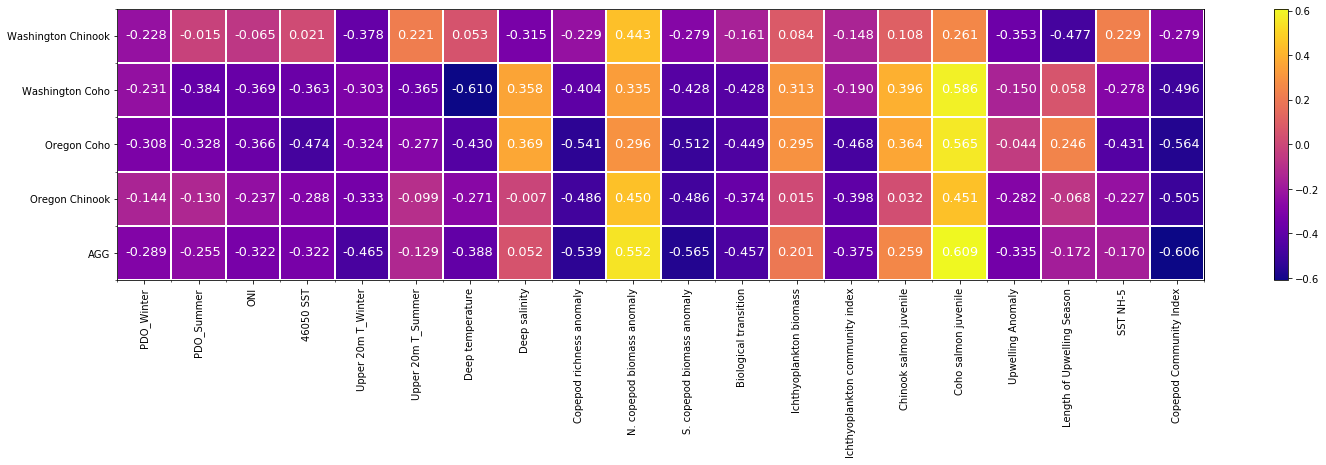

In [64]:
target_feature_corr_dict = {}
tmp_dict = {}

for f in features:
    data_arr = []
    for t in targets:

        x_val = x[:, features_vocab[f]]
        y_val = y[:, targets_vocab[t]]

        corr, p_value = pearsonr(x_val, y_val)

        data_arr.append([corr, p_value])


    target_feature_corr_dict[f] = data_arr
    tmp_dict[f] = [r[0] for r in data_arr]


corr_df = pd.DataFrame(tmp_dict)
corr_df.index = targets

# corr_df.head()

corr_mat = corr_df.values

plt.figure(figsize=(25,5))
plt.imshow(corr_mat, interpolation='none', cmap='plasma')

ax = plt.gca();

len_y, len_x = corr_df.shape

x_tick_mark = np.arange(len_x)
y_tick_mark = np.arange(len_y)

plt.xticks(x_tick_mark, corr_df.columns, rotation=90)
plt.yticks(y_tick_mark, corr_df.index)

ax.set_xticks(np.arange(-.5, len_x, 1), minor=True);
ax.set_yticks(np.arange(-.5, len_y, 1), minor=True);

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

for i in range(len_x):
    for j in range(len_y):
#         print(i, '-',j)
        plt.text(i-0.35,j+0.05, "%.3f"%corr_mat[j][i], color='w', fontsize=13)


plt.colorbar()

plt.show()

In [67]:
def plot_filtered_correlation(target):
    indicator_corr_dict = corr_df.T[target].to_dict()
    indicator_corr_dict = { k:v for k, v in indicator_corr_dict.items() if abs(v) > 0.4 }
    sorted_indicator_corr_dict = sorted(indicator_corr_dict.items(), key = lambda x:x[1], reverse=True)

    sorted_indicator_lst = [k for k,v in sorted_indicator_corr_dict]
    sorted_corr_val_lst = [v for k,v in sorted_indicator_corr_dict]

    bar_col = ['r' if i < 0 else 'b' for i in sorted_corr_val_lst]

    tmp_xtick = range(len(sorted_indicator_corr_dict))
    plt.barh(tmp_xtick, sorted_corr_val_lst, color = bar_col)

    plt.yticks(tmp_xtick, sorted_indicator_lst)
    plt.title("Indicators with Significant Correlation for %s" % target)

    ylabel("Indicator")
    xlabel("Correlation Score")
    plt.show()

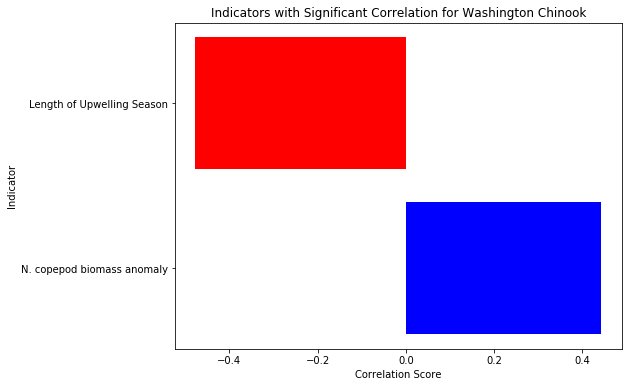

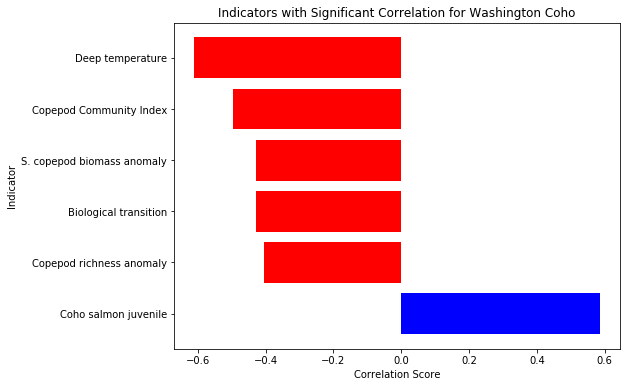

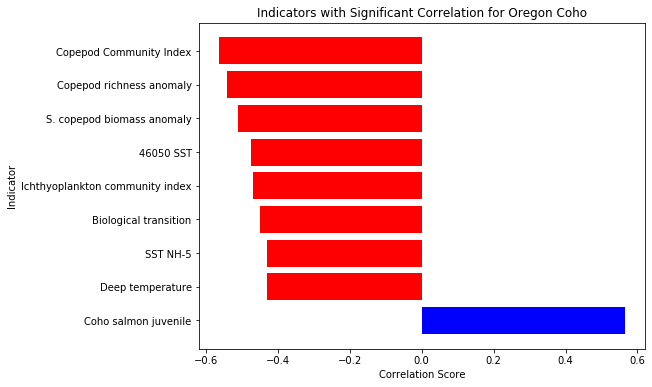

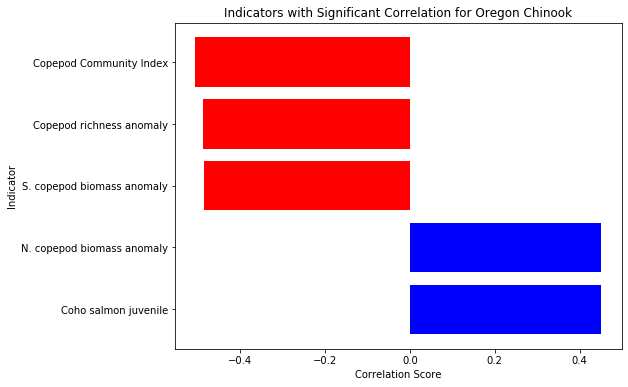

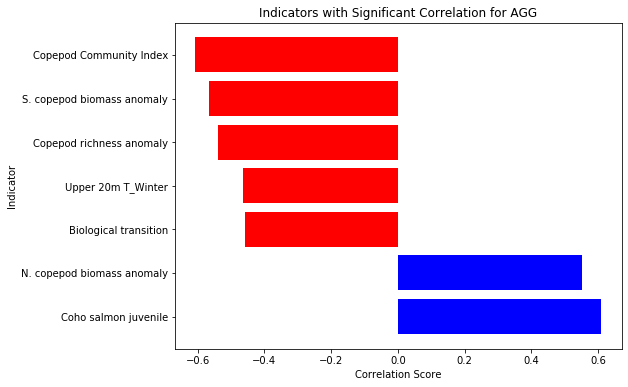

In [68]:
for t in targets:
    plot_filtered_correlation(t)

## Part C - Prediction model

### A. Ensemble model with 20 variables 
_Using the 20 variables above, can we create a predictive model for Salmon production?_

Instead of relying on one model to predict the data, I'm using an esemble of models that include:
- Linear Regression
- Ridge
- Lasso
- Support Vector Regression  

This ensemble model will select the best results among the models. It will also use the best hyperparameters found using _GridSearch function_ in SKlearn.  
Due to the small sample size, a _cross validation_ technique will be employed to train model on 80% of the data, and test it on 20% of the data. This process is then repeated 20 times to get the average prediction value on a given year


In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from mlxtend.regressor import StackingRegressor

# Initializing models

lr = LinearRegression()
svr_lin = SVR(kernel='linear')
ridge = Ridge(random_state=1)
lasso = Lasso(random_state=1)
svr_rbf = SVR(kernel='rbf')
regressors = [svr_lin, lr, ridge, lasso]
stregr = StackingRegressor(regressors=regressors, 
                           meta_regressor=svr_rbf)

params = {'lasso__alpha': [0.1, 1.0, 10.0],
          'ridge__alpha': [0.1, 1.0, 10.0],
          'svr__C': [0.1, 1.0, 10.0],
          'meta_regressor__C': [0.1, 1.0, 10.0, 100.0],
          'meta_regressor__gamma': [0.1, 1.0, 10.0]}

grid = GridSearchCV(estimator=stregr, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
for t in targets:
    corr_arr_tmp = corr_df.T[t].to_dict()

    corr_arr_tmp = sorted(corr_arr_tmp.items(), key = lambda x: abs(x[1]))

    sorted_idx_arr = [features_vocab[i] for i, v in corr_arr_tmp]

    x_train = x[:, sorted_idx_arr[:9]]
    y_train = y[:, targets_vocab[t]]

X_data = x[:, sorted_idx_arr[:9]]
y_data = y[:, targets_vocab[t]]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.6, random_state=42)

grid.fit(X_test, y_test)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: -0.912613 using {'lasso__alpha': 1.0, 'meta_regressor__C': 0.1, 'meta_regressor__gamma': 0.1, 'ridge__alpha': 10.0, 'svr__C': 0.1}


In [95]:
def cross_val2(t, ml_model, n_run = 20):

    corr_arr_tmp = corr_df.T[t].to_dict()
    corr_arr_tmp = sorted(corr_arr_tmp.items(), key = lambda x: abs(x[1]))
    sorted_idx_arr = [features_vocab[i] for i, v in corr_arr_tmp]
    
    X_data = x[:, sorted_idx_arr[:9]]
    y_data = y[:, targets_vocab[t]]

    rkf = RepeatedKFold(n_splits=5, n_repeats=n_run, random_state=312412)

    plt.figure(figsize=(13,5))

    mse_lst = []

    pred_dict = {year:[] for year in x_year_range}

    plt.scatter(x_year_range, y_data, color = 'b')

    for train_index, test_index in rkf.split(X_data):
        X_train, X_test = X_data[train_index], X_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]

        model = ml_model
        results = model.fit(X_train, y_train)

        y_pred = results.predict(X_test)

        for idx, year in enumerate(x_year_range[test_index]):
            pred_dict[year].append(y_pred[idx])

        residual = (y_test - y_pred)**2
        mse = np.mean(residual)

        mse_lst.append(mse)

        # plot
        plt.scatter(x_year_range[test_index], y_pred, color = (0.85, 0.85, 0.85))
    #     print(x_year_range[test_index])
    #     plt.plot(results.fittedvalues, color = 'r')

    print("Average mse of %d run through is %.3f" % (n_run, np.mean(mse_lst)))

    mean_pred_lst = [np.mean(pred_dict[year]) for year in x_year_range]
    median_pred_lst = [np.median(pred_dict[year]) for year in x_year_range]


    plt.scatter(x_year_range[test_index], y_pred, color = (0.85, 0.85, 0.85), label = 'Prediction')
    # print(x_year_range[test_index])
    plt.scatter(x_year_range, y_data, color = 'b', label = 'Actual')

    plt.scatter(x_year_range, mean_pred_lst, color = (0.9, 0.1, 0.1), label = 'Mean Prediction')
    plt.scatter(x_year_range, median_pred_lst, color = (0.1, 0.9, 0.2, 0.7), label = 'Median Prediction')
    rcParams['lines.markersize'] = 5
    
    plt.legend()

    plt.title('%s Actual vs Prediction \n cross validation %d times \n(Ensemble models with Grid Search)' % (t, n_run))
    plt.xlabel("Year")
    plt.ylabel("Pounds")
    plt.show()

***Results***  
Overall, the accuracy is not desirable. There are several years of extreme predictions that could be explained by the occurrence of El-Nino & La-Nina, but not most of them. I suspect that this have a lot to do with the small number of sample used in training the model. Also, by looking at the pattern for actual data, I suspect there's a non-linear relationship between independent variables and Salmon production.

Average mse of 20 run through is 1.038


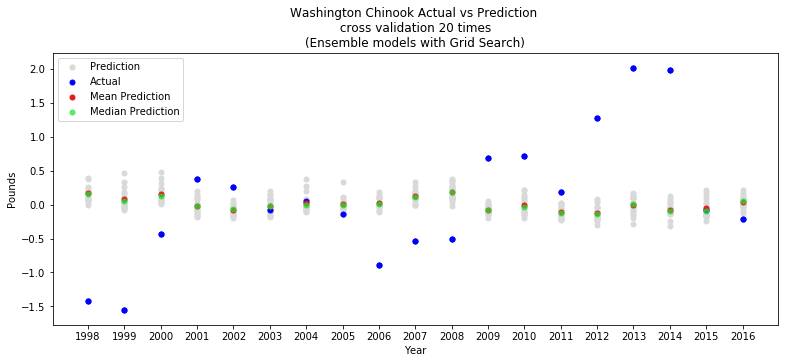

Average mse of 20 run through is 1.032


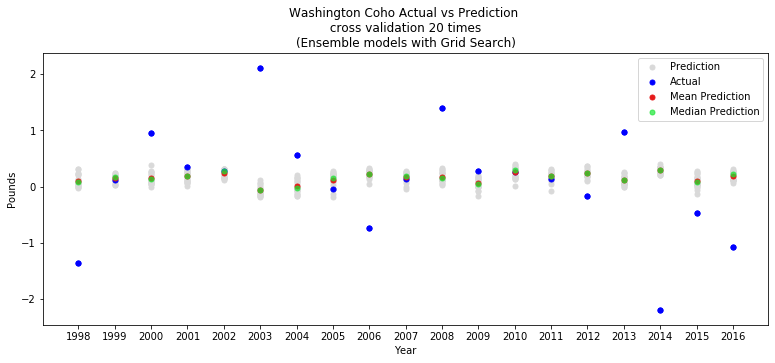

Average mse of 20 run through is 1.259


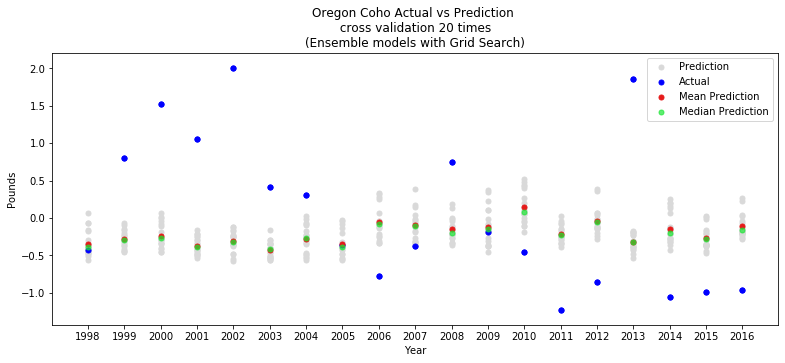

Average mse of 20 run through is 1.486


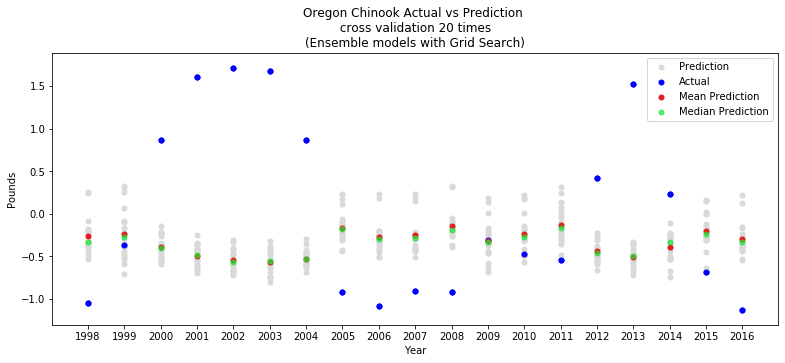

Average mse of 20 run through is 1.131


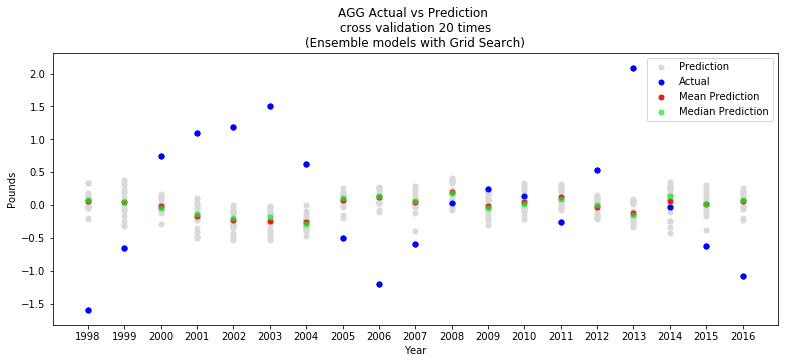

In [96]:
rcParams['lines.markersize'] = 5

best_grid = grid.best_estimator_
for t in targets:
    cross_val2(t,best_grid)

### B. Dimension Reduction with PCA
_Is there a benefit by reducing the number of independent variables?_

Instead of using all 20 variables, an improvement on model performance can be found by using the principal components as independent variables. 

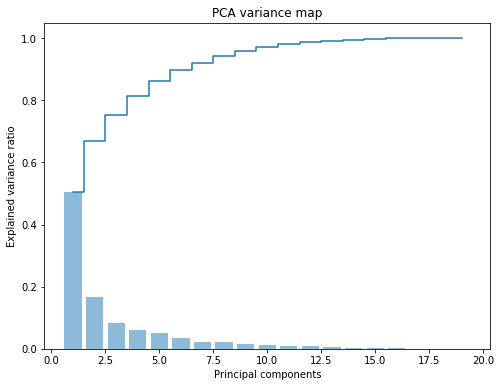

In [71]:
num_component = 3

pca_all = PCA()

principalComponents_all = pca_all.fit_transform(x)

var_ratio_lst = pca_all.explained_variance_ratio_
var_ratio_len = len(var_ratio_lst)
plt.bar(range(1,var_ratio_len+1), var_ratio_lst, align='center', alpha=0.5)
plt.step(range(1,var_ratio_len+1), np.cumsum(var_ratio_lst), where='mid')
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.title("PCA variance map")
plt.show()

According to the graph above, the first 3 principal components already explain more than 75% of the total variance. Therefore, I'm going to use these 3 PCA as independent variables in my model

In [72]:
num_component = 3

pca = PCA(n_components=num_component)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ["p_component %d" % (i+1) for i in range(num_component)])

In [73]:
def linear_regression_plot(x_train, y_train, title = 'Title'):
    
    x_train = sm.add_constant(x_train)
    model = sm.OLS(y_train, x_train)

    results = model.fit()
    
    mse_tot = results.mse_total
    r_sq = results.rsquared
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

    axes[0].scatter(x_year_range, y_train)
    axes[0].plot(results.fittedvalues, color = 'r')
    axes[0].title.set_text('Actual vs Prediction')
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("Pounds")
    
    axes[0].legend(["Linear Regression Model | r_sq = %.3f"%(r_sq), "data"])
    
    fig.suptitle(title, fontsize=16,y=1.02)

    axes[1].scatter(x_year_range, results.resid)
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].title.set_text('Residual')
    axes[1].legend(["Total mean squared error = %.3f"%(mse_tot)])
    axes[1].set_xlabel("Year")

    fig.tight_layout()
    plt.show()
    
    return model, results

### 1. Linear Regression only


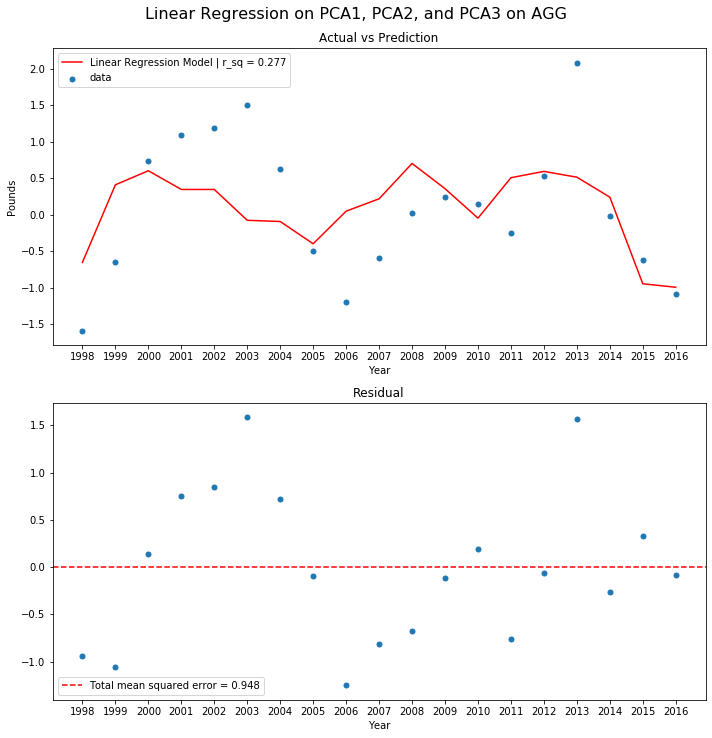

In [97]:
targets = ['AGG']

for t in targets:
    # Extract feature and target
    x_train = principalComponents
    y_train = y[:, targets_vocab[t]]
    mod, res = linear_regression_plot(x_train, y_train, title = "Linear Regression on PCA1, PCA2, and PCA3 on " + t)

### 2. Cross validation with 3 PCA

In [75]:
def cross_val_3pca(t, n_run = 20):

    corr_arr_tmp = corr_df.T[t].to_dict()
    corr_arr_tmp = sorted(corr_arr_tmp.items(), key = lambda x: abs(x[1]))
    sorted_idx_arr = [features_vocab[i] for i, v in corr_arr_tmp]
    
    X_data = principalComponents
    y_data = y[:, targets_vocab[t]]

    rkf = RepeatedKFold(n_splits=5, n_repeats=n_run, random_state=312412)

    plt.figure(figsize=(13,5))

    mse_lst = []

    pred_dict = {year:[] for year in x_year_range}

    plt.scatter(x_year_range, y_data, color = 'b')

    for train_index, test_index in rkf.split(X_data):
        X_train, X_test = X_data[train_index], X_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]

        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test)
        
        model = sm.OLS(y_train, X_train)
        results = model.fit()

        y_pred = results.predict(X_test)

        for idx, year in enumerate(x_year_range[test_index]):
            pred_dict[year].append(y_pred[idx])

        residual = (y_test - y_pred)**2
        mse = np.mean(residual)

        mse_lst.append(mse)

        # plot
        plt.scatter(x_year_range[test_index], y_pred, color = (0.85, 0.85, 0.85))
    #     print(x_year_range[test_index])
    #     plt.plot(results.fittedvalues, color = 'r')

    print("Average mse of %d run through is %.3f" % (n_run, np.mean(mse_lst)))

    mean_pred_lst = [np.mean(pred_dict[year]) for year in x_year_range]
    median_pred_lst = [np.median(pred_dict[year]) for year in x_year_range]

    
    plt.scatter(x_year_range[test_index], y_pred, color = (0.85, 0.85, 0.85), label = 'Prediction')
    # print(x_year_range[test_index])
    plt.scatter(x_year_range, y_data, color = 'b', label = 'Actual')

    plt.scatter(x_year_range, mean_pred_lst, color = (0.9, 0.1, 0.1), label = 'Mean Prediction')
    plt.scatter(x_year_range, median_pred_lst, color = (0.1, 0.9, 0.2, 0.7), label = 'Median Prediction')
    rcParams['lines.markersize'] = 5
    
    plt.legend()
    
    plt.title('%s Actual vs Prediction \n cross validation %d times \n (PCA)' % (t, n_run))
    plt.xlabel("Year")
    plt.ylabel("Pounds")
    plt.show()

Average mse of 20 run through is 1.271


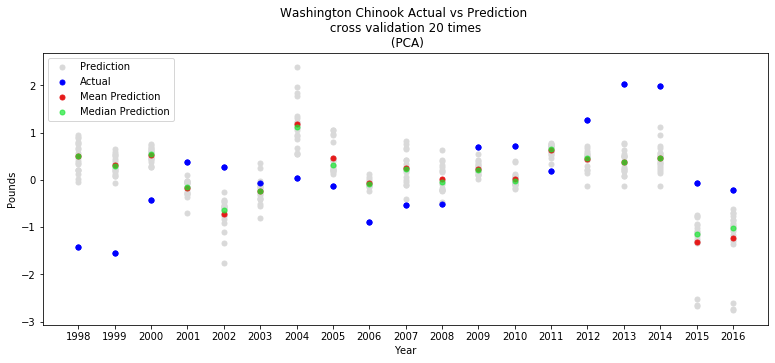

Average mse of 20 run through is 1.213


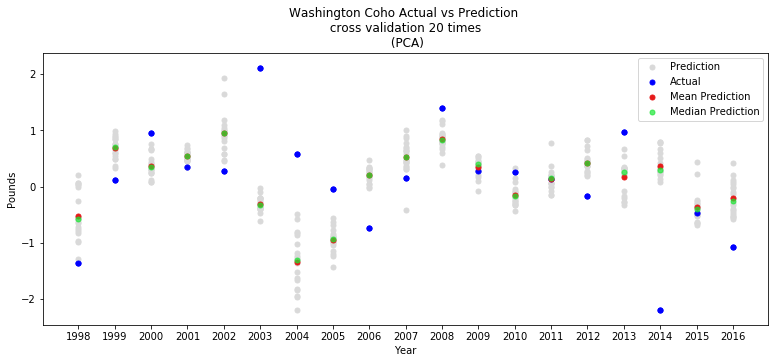

Average mse of 20 run through is 1.191


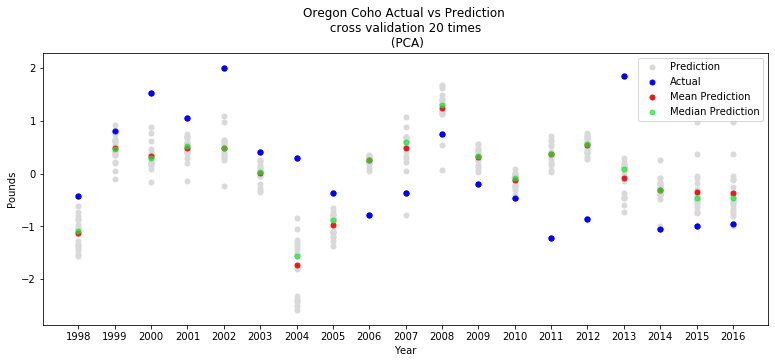

Average mse of 20 run through is 1.518


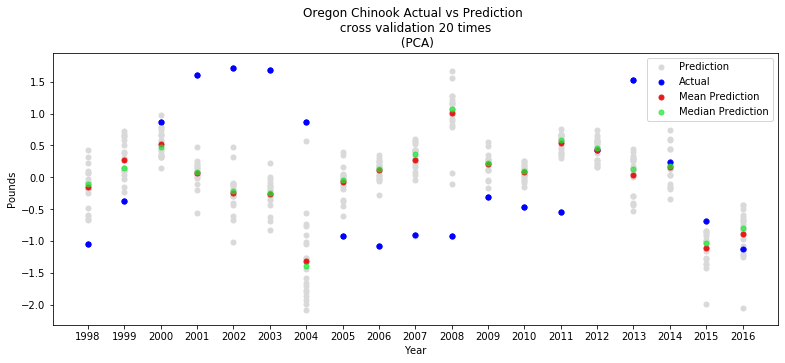

Average mse of 20 run through is 1.077


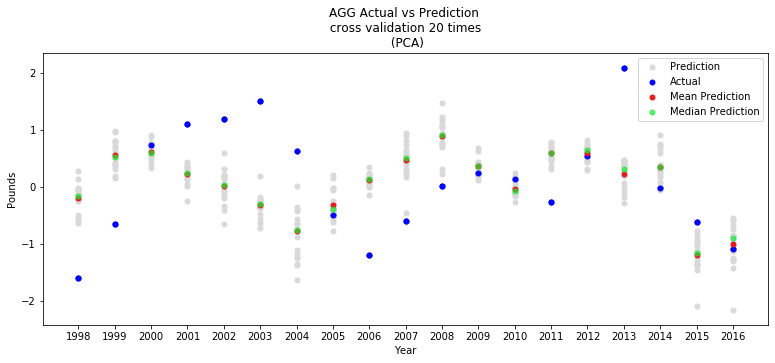

In [76]:
for t in targets:
    cross_val_3pca(t)

### 3. Cross Validation with 3 PCA using Ensemble model

In [78]:
def cross_val3(t, ml_model, n_run = 20):

    corr_arr_tmp = corr_df.T[t].to_dict()
    corr_arr_tmp = sorted(corr_arr_tmp.items(), key = lambda x: abs(x[1]))
    sorted_idx_arr = [features_vocab[i] for i, v in corr_arr_tmp]
    
    X_data = principalComponents
    y_data = y[:, targets_vocab[t]]

    rkf = RepeatedKFold(n_splits=5, n_repeats=n_run, random_state=312412)

    plt.figure(figsize=(13,5))

    mse_lst = []

    pred_dict = {year:[] for year in x_year_range}

    plt.scatter(x_year_range, y_data, color = 'b')

    for train_index, test_index in rkf.split(X_data):
        X_train, X_test = X_data[train_index], X_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]

        model = ml_model
        results = model.fit(X_train, y_train)

        y_pred = results.predict(X_test)

        for idx, year in enumerate(x_year_range[test_index]):
            pred_dict[year].append(y_pred[idx])

        residual = (y_test - y_pred)**2
        mse = np.mean(residual)

        mse_lst.append(mse)

        # plot
        plt.scatter(x_year_range[test_index], y_pred, color = (0.85, 0.85, 0.85))
    #     print(x_year_range[test_index])
    #     plt.plot(results.fittedvalues, color = 'r')

    print("Average mse of %d run through is %.3f" % (n_run, np.mean(mse_lst)))

    mean_pred_lst = [np.mean(pred_dict[year]) for year in x_year_range]
    median_pred_lst = [np.median(pred_dict[year]) for year in x_year_range]


    plt.scatter(x_year_range[test_index], y_pred, color = (0.85, 0.85, 0.85), label = 'Prediction')
    # print(x_year_range[test_index])
    plt.scatter(x_year_range, y_data, color = 'b', label = 'Actual')

    plt.scatter(x_year_range, mean_pred_lst, color = (0.9, 0.1, 0.1), label = 'Mean Prediction')
    plt.scatter(x_year_range, median_pred_lst, color = (0.1, 0.9, 0.2, 0.7), label = 'Median Prediction')
    rcParams['lines.markersize'] = 5
    
    plt.legend()

    plt.title('%s Actual vs Prediction \n cross validation %d times \n(Ensemble models with Grid Search on PCA)' % (t, n_run))
    plt.xlabel("Year")
    plt.ylabel("Pounds")
    plt.show()

Average mse of 20 run through is 1.006


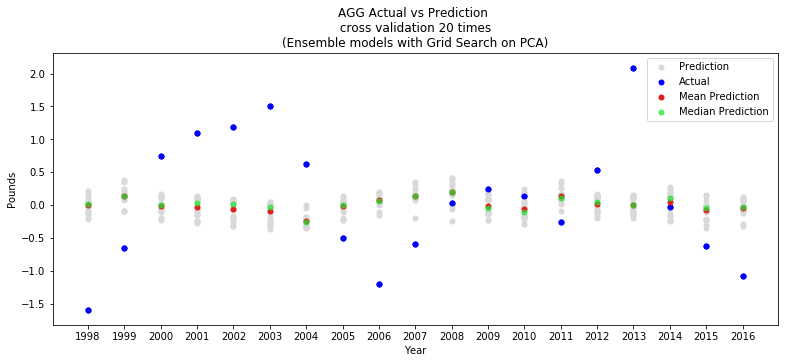

In [99]:
for t in targets:
    cross_val3(t,best_grid)

# Conclusions

Large scale correlation analysis confirms the existence of a relationship between macro environmental indicator (SST) & local environmental indicators on Salmon productivity in the U.S. Specifically, Sea Surface Temperature can be used as a good predictive indicator for Salmon productivity. When comparing the Sea Surface Temperature between the high production years (95th percentile) and the low production years (5th percentile), there is a clear difference between between the two group. The sea surface temperature was warmer during the low production year, and colder during the high production year. This is consistent with the understanding that Salmon thrives in a cold-water environment. Additionally, the correlation map between Salmon landings and global Sea Surface Temperature reveals areas of high correlation near the equator and south of the Pacific Ocean, which is consistence with the patterns of El Nino & La Nina. SST is also an important feature to Salmon production on a local scale. Most of the biological indicators shows high correlation with the production data, confirming the relationships that were identified by previous studies.

A prediction framework that employs various machine learning techniques yields a mixed results. First prediction model using all available variables achieves an average Mean Squared Error of 1.131 after 20 runs. Overall, the accuracy is not desirable. There are several years of extreme predictions that could be explained by the occurrence of El-Nino & La-Nina. The other prediction model using 3 principal components as independent variables achieves a slightly better Mean Squared Error value than the first one after 20 runs. However, this outcome is expected given the small data sample. A better results could be achieved if a larger dataset is available.